# Analysis of the Netflix catalogue
## Visualization, data mining and prediction of data
This notebook contains the results by using the aformentioned techniques in order to get an understanding of how the netflix catalogue has evolved over the years as well as representing the data in an understandable manner.

Most of the python code that does the heavy lifting i.e data sanitizing, crunching of numbers and magic resides in seperate .py files in order to keep the notbook clean, only featuring code that is relevant for plot and other visualization.



# Python setup
### We recommend opening this notebook using JupyterLab in order to be able to view all the interactive plots.

In [1]:
import os
import yrs_months


# Running main python script.
%run -i "main.py"

# Data set from main.py
data_set

analyse gender representation? *takes up to 10 minutes* hit: [y]n


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,Unknown director,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,Unknown director,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,Unknown director,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...
...,...,...,...,...,...,...,...,...,...,...,...,...
6229,80000063,TV Show,Red vs. Blue,Unknown director,"Burnie Burns, Jason Saldaña, Gustavo Sorola, G...",United States,Unknown date_added,2015,NR,13 Seasons,"TV Action & Adventure, TV Comedies, TV Sci-Fi ...","This parody of first-person shooter games, mil..."
6230,70286564,TV Show,Maron,Unknown director,"Marc Maron, Judd Hirsch, Josh Brener, Nora Zeh...",United States,Unknown date_added,2016,TV-MA,4 Seasons,TV Comedies,"Marc Maron stars as Marc Maron, who interviews..."
6231,80116008,Movie,Little Baby Bum: Nursery Rhyme Friends,Unknown director,Unknown cast,Unknown country,Unknown date_added,2016,Unknown rating,60 min,Movies,Nursery rhymes and original music for children...
6232,70281022,TV Show,A Young Doctor's Notebook and Other Stories,Unknown director,"Daniel Radcliffe, Jon Hamm, Adam Godley, Chris...",United Kingdom,Unknown date_added,2013,TV-MA,2 Seasons,"British TV Shows, TV Comedies, TV Dramas","Set during the Russian Revolution, this comic ..."


# Genre analysis

## Most Popular movie and series genres
### Discarding the 'movie' and 'tv show'  entry in the genre list and 

In [2]:
# Import packages needed for visualization
import datetime as dt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud
import chord # Need to install - pip install chord

In [3]:
# Split genres into list on comma and put each item on separate line
genres = data_set['listed_in'].dropna().str.split(', ').explode().copy()

Use word cloud to visualize the most frequent genres in the Netflix library, requires wordcloud. Run pip install wordcloud

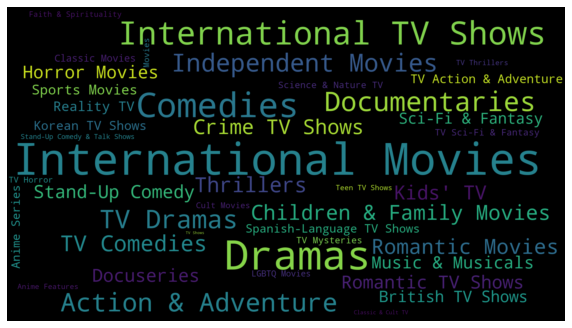

In [4]:
# Make word cloud using frequency of genres.

plt.subplots(figsize=(10,10))
wordcloud = WordCloud(
                          background_color='Black',
                          width=1920,
                          height=1080
                         ).generate_from_frequencies(genres.value_counts())
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

C:\Users\ASLAKSK\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


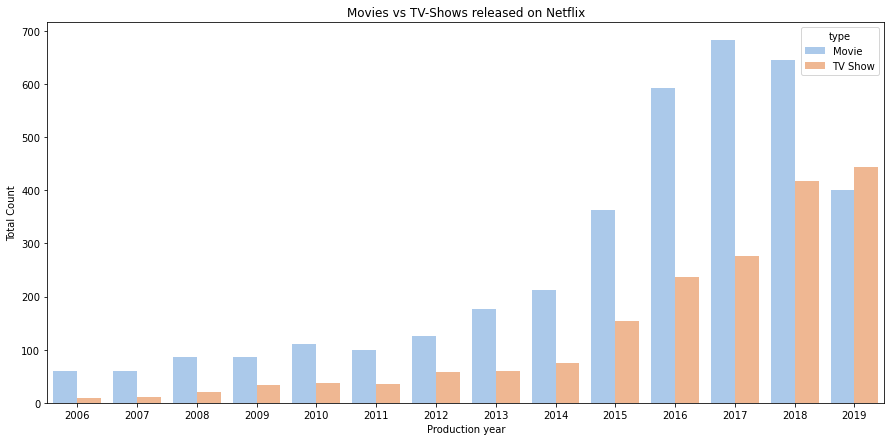

In [5]:
netflix_data = data_set
order =  sorted(netflix_data.release_year.unique())[-15:-1]
plt.figure(figsize=(15,7))
g = sns.countplot(netflix_data.release_year, hue=netflix_data.type, order=order, palette="pastel");
plt.title("Movies vs TV-Shows released on Netflix")
plt.xlabel("Production year")
plt.ylabel("Total Count")
plt.show()

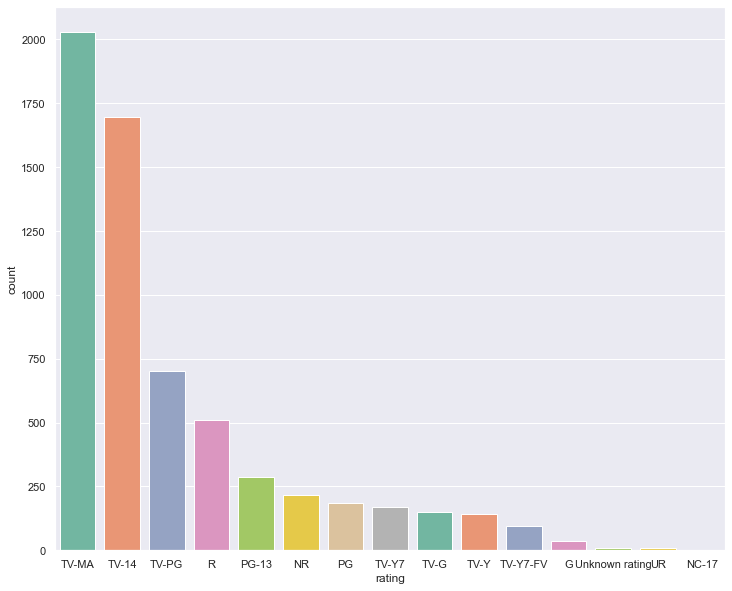

In [6]:
plt.figure(figsize=(12,10))
sns.set(style="darkgrid")
ax = sns.countplot(x="rating", data=netflix_data, palette="Set2", order=netflix_data['rating'].value_counts().index[0:15])

In [7]:
rating_order =  ['G', 'TV-Y', 'TV-G', 'PG', 'TV-Y7', 'TV-Y7-FV', 'TV-PG', 'PG-13', 'TV-14', 'R', 'NC-17', 'TV-MA']

movie_rating = netflix_data['rating'].value_counts()
#tv_rating = tv_show['rating'].value_counts()[rating_order].fillna(0)

In [8]:
replacements = {
        "& Talk": "",
        "Classic & Cult": "Classic, Cult",
        "Features": "",
        "Series": "",
        "Comedy": "Comedies",
        "British": "International",
        "Spanish-Language": "International",
        "Children & Family": "Kids'",
        "TV Shows": "",
        "Movies": "",
        "Docuseries": "Documentaries",
        "& Talk Shows": "",
        "Stand-Up": "",
        "TV": "",
        "Shows": "",
        " ": "",
    }

temp2 = netflix_data.copy()
temp2.listed_in = temp2.listed_in.replace(replacements, regex=True).str.split(',').apply(lambda x: [i for i in x if i != 'International'])

In [9]:
temp3 = temp2.explode('listed_in')
temp3 = temp3.rename(columns={'listed_in': 'Genre', 'rating': 'PG-Rating'})
df = temp3.groupby(['Genre','PG-Rating']).size().unstack(fill_value=0)
df = df[df > 0].fillna(0)

df[1:]

PG-Rating,G,NC-17,NR,PG,PG-13,R,TV-14,TV-G,TV-MA,TV-PG,TV-Y,TV-Y7,TV-Y7-FV,UR,Unknown rating
Genre,,,,,,,,,,,,,,,
Action&Adventure,1.0,0.0,29.0,19.0,100.0,124.0,182,1.0,224.0,31,0.0,2.0,8.0,2.0,0.0
Anime,0.0,0.0,12.0,1.0,4.0,0.0,72,0.0,36.0,16,1.0,16.0,3.0,0.0,1.0
Classic,7.0,0.0,5.0,11.0,9.0,21.0,18,3.0,12.0,22,0.0,0.0,0.0,0.0,0.0
Comedies,10.0,1.0,56.0,96.0,103.0,124.0,501,46.0,656.0,190,12.0,58.0,16.0,2.0,1.0
Crime,0.0,0.0,4.0,0.0,0.0,0.0,123,1.0,228.0,4,0.0,1.0,2.0,0.0,0.0
Cult,0.0,0.0,6.0,1.0,10.0,29.0,9,1.0,10.0,13,0.0,0.0,0.0,0.0,0.0
Documentaries,6.0,0.0,42.0,15.0,16.0,17.0,273,61.0,297.0,218,1.0,1.0,0.0,0.0,0.0
Dramas,2.0,1.0,96.0,38.0,103.0,252.0,720,11.0,771.0,218,0.0,4.0,0.0,5.0,1.0
Faith&Spirituality,0.0,0.0,0.0,10.0,5.0,0.0,19,1.0,0.0,12,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'Genre vs PG Rating')

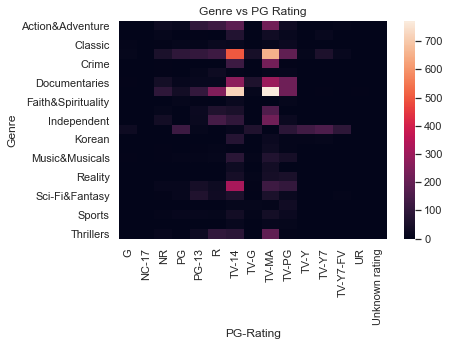

In [10]:
sns.heatmap(df[1:]).set_title("Genre vs PG Rating")

Want to plot the genres and total count of each genre. 
Separate into movies and tv shows.
Decided to remove categories International Movies and International TV shows as these were overrepresented in the data set as they are given to all movies not from the US. This category is always coupled with another gerne and is therefore not seen as one of the main genres.

In [11]:
# Extract movie genres
genres_movies = data_set[data_set["type"]=="Movie"]['listed_in'].dropna().str.split(', ').explode().copy()

Text(0.5, 0, 'Total Count')

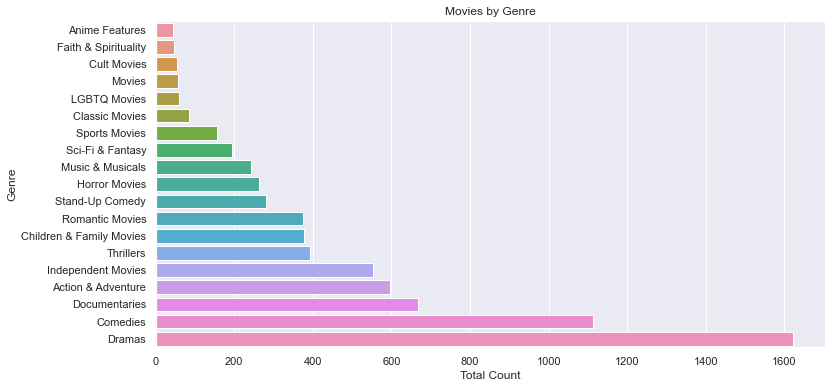

In [12]:
# Plot bar plot of all movie genres
plt.figure(figsize=(12,6))
sns.countplot(y=genres_movies, order=genres_movies.value_counts(ascending=True).index[:-1]) #removed international movies
plt.title("Movies by Genre")
plt.ylabel("Genre")
plt.xlabel("Total Count")

In [13]:
#Extract TV genres
genres_tv = data_set[data_set["type"]=="TV Show"]['listed_in'].dropna().str.split(', ').explode().copy()

Text(0.5, 0, 'Total Count')

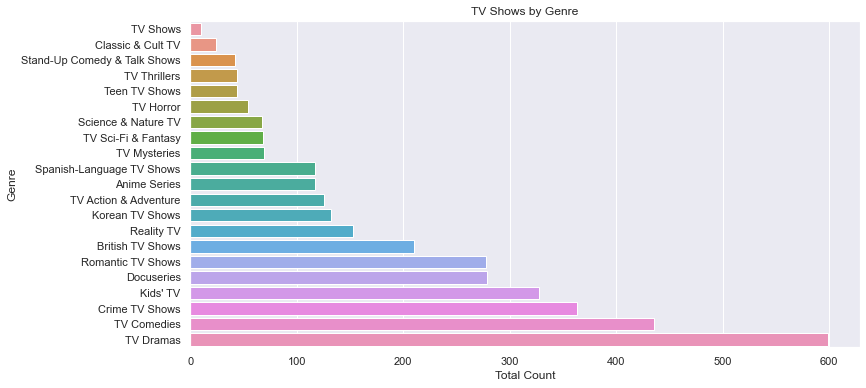

In [14]:
# Plot TV genre count
plt.figure(figsize=(12,6))
sns.countplot(y=genres_tv, order=genres_tv.value_counts(ascending=True).index[:-1]) # Removed international TV shows
plt.title("TV Shows by Genre")
plt.ylabel("Genre")
plt.xlabel("Total Count")

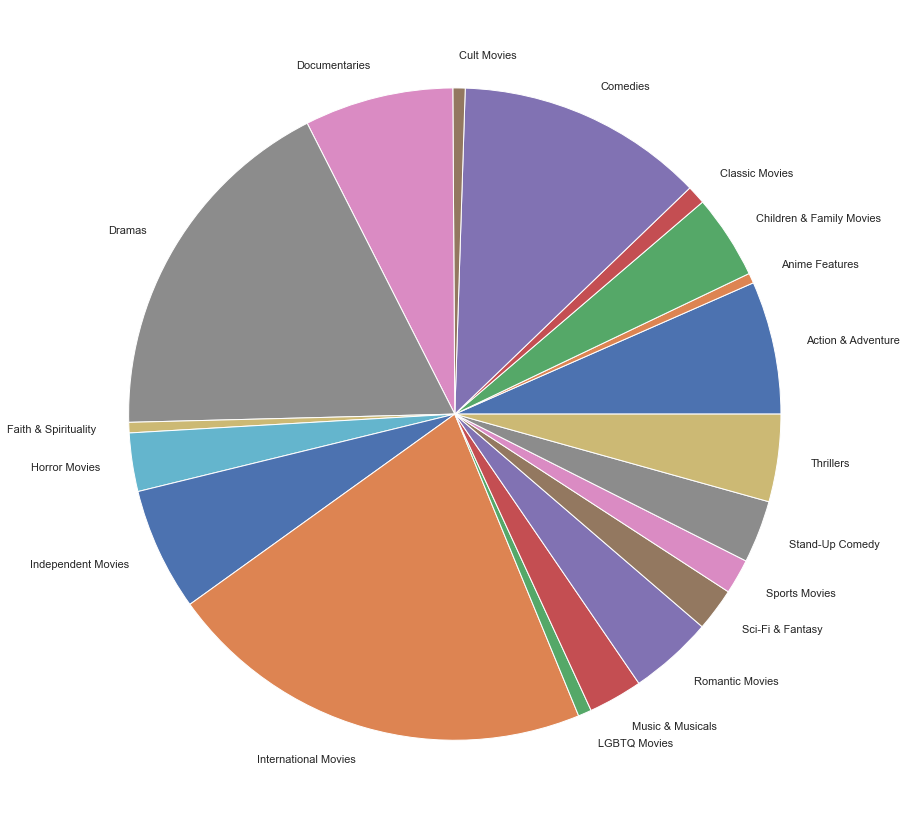

In [15]:
plt.figure(figsize = (15,15))
plt.pie(
    [genre_value for genre_value in pop_movie_genre.values()],
    labels=[genre_keys for genre_keys in pop_movie_genre.keys()],
    autopct=None
)
plt.show()

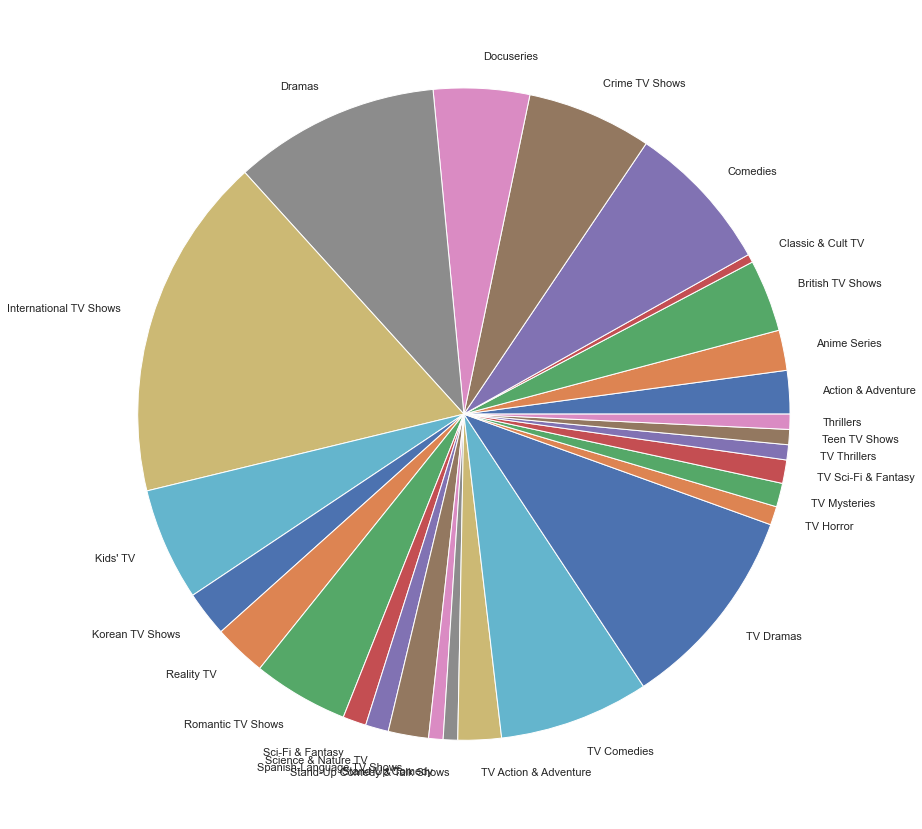

In [16]:
plt.figure(figsize = (15,15))
plt.pie(
    [genre_value for genre_value in pop_series_genre.values()],
    labels=[genre_keys for genre_keys in pop_series_genre.keys()],
    autopct=None
)
plt.show()


Look at the 5 most frequent movie and TV genres and plot with gear added to see if there are any patterns.
International TV shows and Movies have again been removed. 

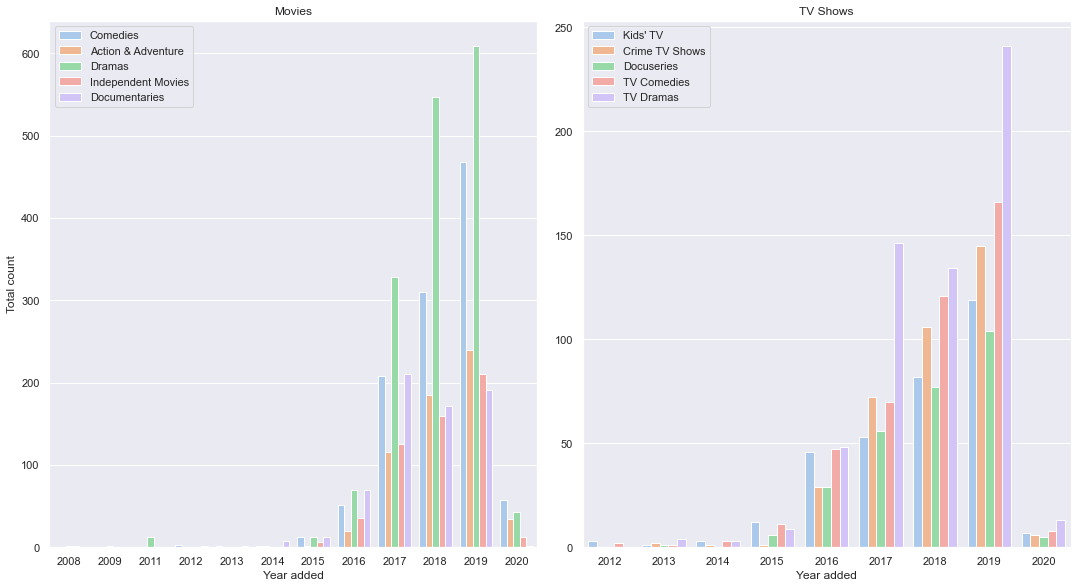

In [17]:
genre_time = data_set[['date_added','listed_in']].copy()
genre_time = genre_time[genre_time['date_added'] != 'Unknown date_added']
genre_time['month_added'] = genre_time['date_added'].str.replace(',', '').str.lstrip().apply(lambda x: dt.datetime.strptime(x,'%B %d %Y')).dt.month_name()
genre_time['year_added'] = genre_time['date_added'].str.replace(',', '').str.lstrip().apply(lambda x: dt.datetime.strptime(x,'%B %d %Y')).dt.year
#year_released = genre_time['date_added']
genre_time['listed_in'] = genre_time['listed_in'].str.split(', ')
genre_time = genre_time.explode('listed_in')
#print(genre_time)

filter_list_m = ['Dramas', 'Comedies', 'Documentaries', 'Action & Adventure', 'Independent Movies']
filter_list_tv = ["TV Dramas", "TV Comedies", "Crime TV Shows", "Kids' TV", "Docuseries"]
top_m_genres = genre_time[genre_time.listed_in.isin(filter_list_m)]
top_tv_genres = genre_time[genre_time.listed_in.isin(filter_list_tv)]


fig, axes = plt.subplots(1, 2, figsize=(15, 8))
#fig.suptitle("Movies TV Shows added to Netflix by Year for top 5 genres")
fig.tight_layout()

sns.countplot(ax=axes[0], x="year_added", hue="listed_in" ,data=top_m_genres, palette="pastel")
axes[0].set_title("Movies")
axes[0].set_xlabel("Year added")
axes[0].set_ylabel("Total count")
axes[0].legend(loc=2)

sns.countplot(ax=axes[1], x="year_added", hue="listed_in" ,data=top_tv_genres, palette="pastel")
axes[1].set_title("TV Shows")
axes[1].set_xlabel("Year added")
axes[1].set_ylabel("")
axes[1].legend(loc=2)


Plot heatplot of genre and year added to Netflix to see if there are any patterns in what genres have been popular over time.

In [18]:
# Create a list of from dataset with month added and genre
year_genre = genre_time[["year_added", "listed_in"]]

# Group month added and genre and make table with value counts
group_y = year_genre.groupby("listed_in")
group_y = group_y['year_added'].value_counts() #count values in month
group_y = group_y.unstack() 
group_y = group_y.fillna(0) #fill nans with 0

# Check table
group_y

year_added,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
listed_in,,,,,,,,,,,,,
Action & Adventure,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,20.0,116.0,185.0,239.0,34.0
Anime Features,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,15.0,8.0,14.0,2.0
Anime Series,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,12.0,30.0,56.0,4.0
British TV Shows,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,19.0,51.0,54.0,75.0,2.0
Children & Family Movies,0.0,0.0,0.0,1.0,2.0,2.0,4.0,11.0,21.0,76.0,86.0,151.0,24.0
Classic & Cult TV,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,10.0,5.0,4.0,0.0
Classic Movies,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,16.0,7.0,49.0,9.0
Comedies,0.0,0.0,0.0,0.0,3.0,1.0,2.0,12.0,51.0,208.0,310.0,468.0,58.0
Crime TV Shows,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,29.0,72.0,106.0,145.0,6.0


Text(0.5, 66.5, 'Month added to Netflix')

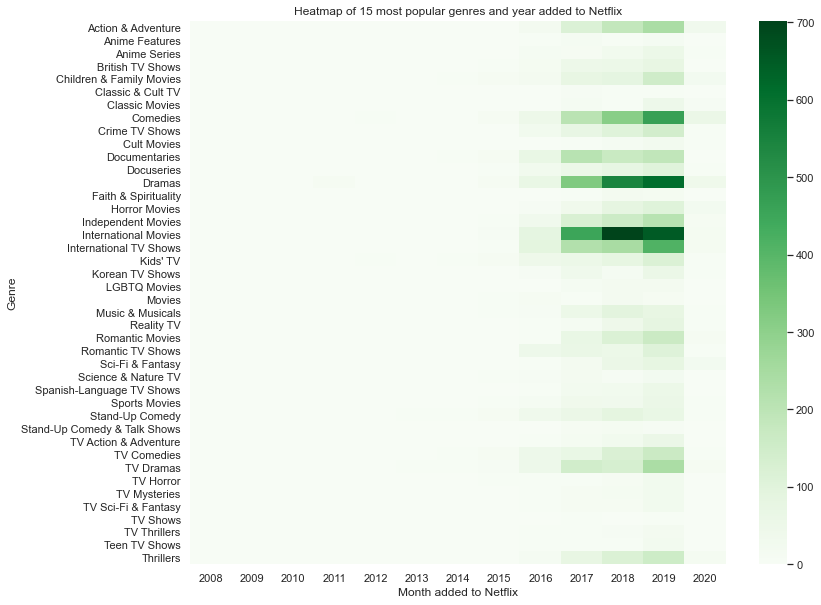

In [19]:
# Plot heatmap
plt.figure(figsize=(12,10))
sns.heatmap(group_y, cmap="Greens")
plt.title("Heatmap of 15 most popular genres and year added to Netflix")
plt.ylabel("Genre")
plt.xlabel("Month added to Netflix")

Heat plot of month added to netflix for 15 most frequent genres. 
Want to check if there is a pattern in when in the year the genres are added to Netflix.

In [20]:
# Create a list of from dataset with year added and genre
month_genre = genre_time[["month_added", "listed_in"]]

# Get most popular genres by value_counts() and only select these from data set
popular_genres = data_set.listed_in.str.split(', ').explode().value_counts().index[:17]
month_genre = month_genre[month_genre.listed_in.isin(popular_genres)]

# Remove International TV shows and International Movies as these are categories that does not give the genre of the movie, only that is was not made in the US. There are overrepresented in the dataset and not that interesting.
month_genre = month_genre[month_genre.listed_in != 'International TV Shows']
month_genre = month_genre[month_genre.listed_in != 'International Movies']

# Group month added and genre and make table with value counts
group = month_genre.groupby("listed_in")
group = group['month_added'].value_counts() #count values in month
group = group.unstack() 
group = group.fillna(0) #fill nans with 0

# Reindex to sort months by calendar and not alphabetically
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
group = group.reindex(columns=months) #sort months according to calendar

# Check table
group

month_added,January,February,March,April,May,June,July,August,September,October,November,December
listed_in,,,,,,,,,,,,
Action & Adventure,68,36,47,33,40,28,42,56,49,62,71,65
Children & Family Movies,54,21,32,23,16,26,25,20,26,47,47,41
Comedies,118,55,110,83,86,59,71,99,71,112,121,128
Crime TV Shows,25,27,36,15,29,28,21,43,36,29,37,36
Documentaries,59,51,62,58,54,48,53,52,53,55,54,69
Docuseries,21,32,27,14,9,12,21,32,33,33,20,24
Dramas,160,111,169,123,105,96,130,114,95,180,153,187
Independent Movies,64,41,56,41,39,39,56,34,39,40,45,58
Kids' TV,40,18,18,21,22,23,29,20,28,40,34,33


Text(0.5, 48.453125, 'Month added to Netflix')

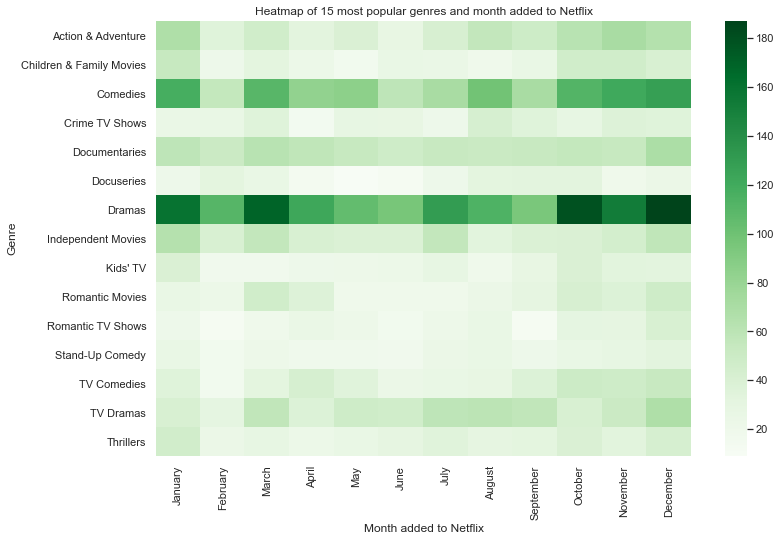

In [21]:
# Plot heatmap
plt.figure(figsize=(12,8))
sns.heatmap(group, cmap="Greens")
plt.title("Heatmap of 15 most popular genres and month added to Netflix")
plt.ylabel("Genre")
plt.xlabel("Month added to Netflix")

Check if there has been a change in added international movies and tv shows.

Text(0.5, 0, 'Year')

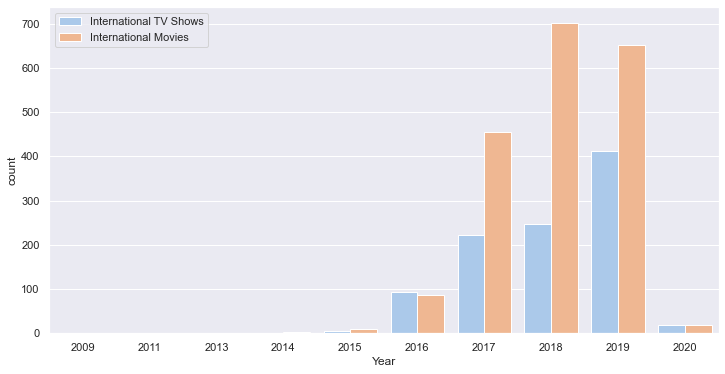

In [22]:
filter_list_int = ["International TV Shows", "International Movies"]
top_int = genre_time[genre_time.listed_in.isin(filter_list_int)]

plt.figure(figsize=(12,6))
sns.countplot(x="year_added", hue="listed_in" ,data=top_int, palette="pastel")
plt.legend(loc=2)
plt.xlabel("Year")

Check most frequent cast in the most frequent movie genres. 

Text(0, 0.5, '')

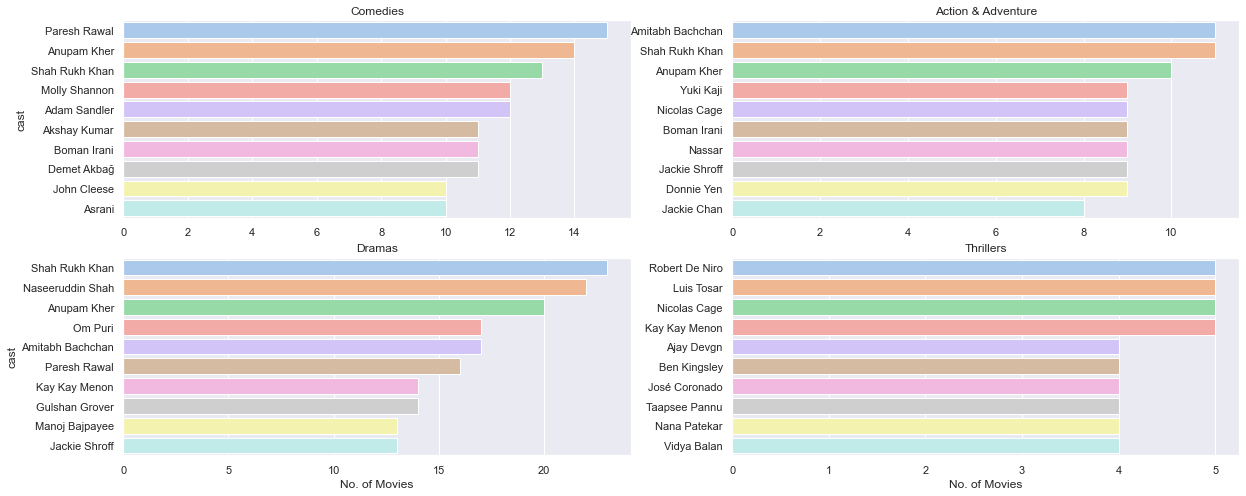

In [23]:
genre_cast = data_set[['cast','listed_in']].copy()
genre_cast = genre_cast[genre_cast['cast'] != 'Unknown cast']
genre_cast['cast'] = genre_cast['cast'].str.split(', ')
genre_cast = genre_cast.explode('cast')

m_per_cast = genre_cast['cast'].value_counts()

genre_cast['listed_in'] = genre_cast['listed_in'].str.split(', ')
genre_cast = genre_cast.explode('listed_in')

top_comedy_cast = genre_cast[genre_cast['listed_in'] == 'Comedies']['cast']

top_action_cast = genre_cast[genre_cast['listed_in'] == 'Action & Adventure']['cast']

top_thriller_cast = genre_cast[genre_cast['listed_in'] == 'Thrillers']['cast']
top_drama_cast = genre_cast[genre_cast['listed_in'] == 'Dramas']['cast']

fig, axes = plt.subplots(2, 2, figsize=(20, 8))
#fig.suptitle("Movies TV Shows added to Netflix by Year for top 5 genres")
#fig.tight_layout()

sns.countplot(ax=axes[0,0], y=top_comedy_cast, palette="pastel", order=top_comedy_cast.value_counts(ascending=False).index[:10])
axes[0,0].set_title("Comedies")
axes[0,0].set_xlabel("")

sns.countplot(ax=axes[0,1], y=top_action_cast, palette="pastel", order=top_action_cast.value_counts(ascending=False).index[:10])
axes[0,1].set_title("Action & Adventure")
axes[0,1].set_xlabel("")
axes[0,1].set_ylabel("")

sns.countplot(ax=axes[1,0], y=top_drama_cast, palette="pastel", order=top_drama_cast.value_counts(ascending=False).index[:10])
axes[1,0].set_title("Dramas")
axes[1,0].set_xlabel("No. of Movies")

sns.countplot(ax=axes[1,1], y=top_thriller_cast, palette="pastel", order=top_thriller_cast.value_counts(ascending=False).index[:10])
axes[1,1].set_title("Thrillers")
axes[1,1].set_xlabel("No. of Movies")
axes[1,1].set_ylabel("")


Check most frequent directors in most frequent movie genres

Text(0, 0.5, '')

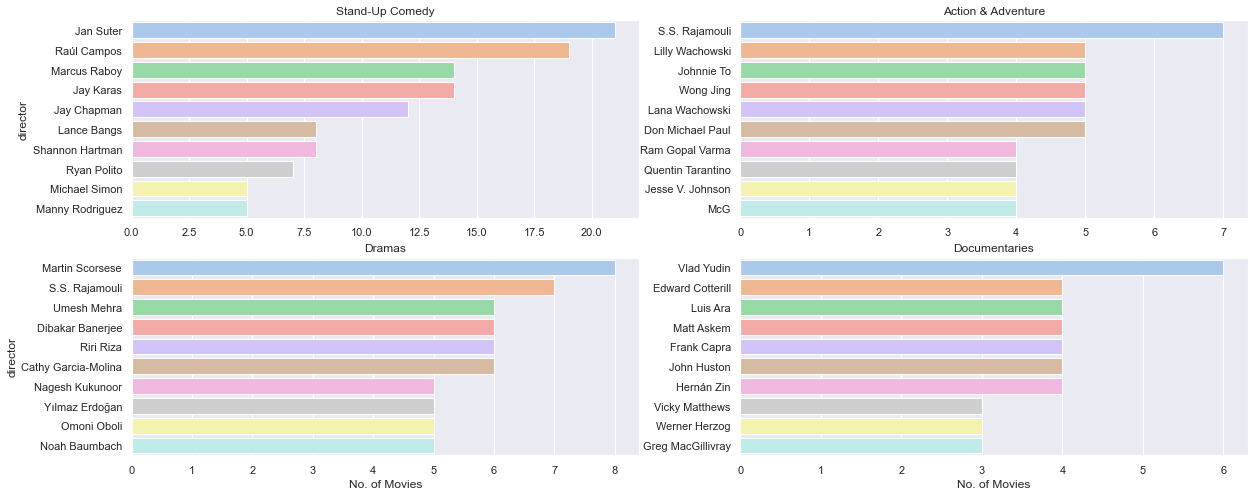

In [24]:
genre_director = data_set[['director','listed_in']].copy()
genre_director = genre_director[genre_director['director'] != 'Unknown director']
genre_director['director'] = genre_director['director'].str.split(',')
genre_director = genre_director.explode('director')
genre_director['director'] = genre_director['director'].str.strip()

m_per_dir = genre_director['director'].value_counts()

genre_director['listed_in'] = genre_director['listed_in'].str.split(',')
genre_director = genre_director.explode('listed_in')
genre_director['listed_in'] = genre_director['listed_in'].str.lstrip()


top_comedy_dir = genre_director[genre_director['listed_in'] == 'Stand-Up Comedy']['director']

top_action_dir = genre_director[genre_director['listed_in'] == 'Action & Adventure']['director']

top_thriller_dir = genre_director[genre_director['listed_in'] == 'Thrillers']['director']
top_doc_dir = genre_director[genre_director['listed_in'] == 'Documentaries']['director']
top_drama_dir = genre_director[genre_director['listed_in'] == 'Dramas']['director']

fig, axes = plt.subplots(2, 2, figsize=(20, 8))
#fig.suptitle("Movies TV Shows added to Netflix by Year for top 5 genres")
#fig.tight_layout()

sns.countplot(ax=axes[0,0], y=top_comedy_dir, palette="pastel", order=top_comedy_dir.value_counts(ascending=False).index[:10])
axes[0,0].set_title("Stand-Up Comedy")
axes[0,0].set_xlabel("")

sns.countplot(ax=axes[0,1], y=top_action_dir, palette="pastel", order=top_action_dir.value_counts(ascending=False).index[:10])
axes[0,1].set_title("Action & Adventure")
axes[0,1].set_xlabel("")
axes[0,1].set_ylabel("")

sns.countplot(ax=axes[1,0], y=top_drama_dir, palette="pastel", order=top_drama_dir.value_counts(ascending=False).index[:10])
axes[1,0].set_title("Dramas")
axes[1,0].set_xlabel("No. of Movies")

sns.countplot(ax=axes[1,1], y=top_doc_dir, palette="pastel", order=top_doc_dir.value_counts(ascending=False).index[:10])
axes[1,1].set_title("Documentaries")
axes[1,1].set_xlabel("No. of Movies")
axes[1,1].set_ylabel("")

# Classifying directors  from heatmap.

### Creating director - genre matrix

In [25]:
populated = director_classification.populate_director_genre_dataframe()

C:\Users\ASLAKSK\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


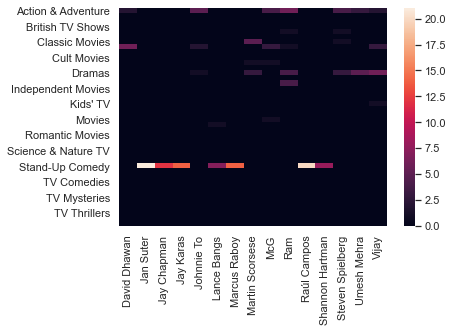

In [26]:
import copy
import seaborn as sns

# Copying dataframe in order to not directly mutating the populated list
# as it takes some time to create the populatedDirector list
copy = copy.copy(populated)

for d in copy:
    # Dropping directors columns that has less that 8 registered movies in total in addition to unknown director.
    if (copy[d].sum() < 8.0 or d == 'Unknown director'):
        copy.drop([d],  axis=1, inplace = True)

sns.heatmap(copy) # Creating heatmap
plt.show()

From this heatmap containing the most active directors in the Netflix catalogue we can "classify" which genre a certain director is. By analysing the heatmap we can clearly state that "Stand-Up Comedy" is the genre that director is most active in and that Jan Suter is a "Stand-Up Comedy" director. McG can be with some certanty be classified as a "Action & Adventure" director.

# Genres added per year (Sander)
## The following plots shows the frequency of when genres were added

In [27]:
import pandas as pd
import numpy as np
import correlation_between_genres
import matplotlib.pyplot as plt
import chord

df = pd.DataFrame(pd.read_csv('netflix_titles.csv'))
dfMovies = df[df['type'] == 'Movie']
dfSeries = df[df['type'] == 'TV Show']

# Handling null values
### Number of movies and series which have missing date for when they were added.

In [28]:
missingMovieDates = len(dfMovies[dfMovies['date_added'].isnull()])
missingSeriesDates = len(dfSeries[dfSeries['date_added'].isnull()])
print('Total number of movies having a unknown date they were added: ', missingMovieDates)
print('Total number of series having a unknown date they were added: ', missingSeriesDates)

Total number of movies having a unknown date they were added:  1
Total number of series having a unknown date they were added:  10


In [29]:
def genresAddedPerYear(df: pd.DataFrame) -> pd.DataFrame:
    # Gets the dates from the dateFrame and converts the format to datetime
    dates = pd.to_datetime(df['date_added'])
    # Removes day and month, as we are only interested in the year
    dates = dates.dt.year


    # Splits the listed_in column into individual genre columns
    genres = correlation_between_genres.genresOfMoviesSeries(df)

    # Puts dates and genres into one table
    genreAdded = correlation_between_genres.genresOfMoviesSeries(df)
    genreAdded.insert(0, 'date_added', dates)

    # Change cells with no value to None
    genreAdded = genreAdded.where(genreAdded.notnull(), None)

    # Name of every genre
    uniqueGenres = correlation_between_genres.totalOccurenceOfGenres(genres).keys().tolist()
    uniqueYears = genreAdded['date_added'].unique()
    # Flip the list to get the columns in the next step in ascending order from left to right
    uniqueYears = np.flip(uniqueYears)
    # Removing nan value
    uniqueYears = uniqueYears[1:]
    uniqueYears = np.sort(uniqueYears)

    genresAddedPerYear = pd.DataFrame(0, index = uniqueGenres, columns=uniqueYears)


    for i, movie in genreAdded.iterrows():
        yearAdded = movie['date_added']
        genresOfMovie = movie[1:4]

        for genre in genresOfMovie:
            if (yearAdded == None or genre == None):
                continue
            genresAddedPerYear[yearAdded][genre] += 1
    
    return genresAddedPerYear

### DataFrame showing how many movies/series with a given genre was added per year. Mind that a movie/series may have multiple genres and the sum of each column isn't the same as at number of movies/series added per year.

In [30]:
genresAddedPerYearSeries = genresAddedPerYear(dfSeries)
genresAddedPerYearMovies = genresAddedPerYear(dfMovies)

### Removing the data in the year 2020 as the year is not over yet and therefore is not representable

In [31]:
genresAddedPerYearSeries = genresAddedPerYearSeries.drop(2020, axis = 'columns')
genresAddedPerYearMovies = genresAddedPerYearMovies.drop(2020, axis = 'columns')

### Displaying DataFrames

In [32]:
display(genresAddedPerYearSeries)
display(genresAddedPerYearMovies)

,2008.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0
International TV Shows,0,0,1,0,5,93,223,246,413
TV Dramas,0,0,4,3,9,48,146,134,241
TV Comedies,0,2,1,3,11,47,70,121,166
Crime TV Shows,0,0,2,1,1,29,72,106,145
Kids' TV,0,3,1,3,12,46,53,82,119
Docuseries,0,0,1,0,6,29,56,77,104
Romantic TV Shows,0,0,0,0,1,47,65,54,108
British TV Shows,0,0,0,0,8,19,51,54,75
Reality TV,0,0,0,0,0,5,16,44,83
Korean TV Shows,0,0,0,0,0,10,39,16,62


,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0
International Movies,0,1,0,1,0,0,2,10,87,455,702,651
Dramas,1,1,0,13,0,0,0,12,69,328,547,609
Comedies,0,0,0,0,3,1,2,12,51,208,310,468
Documentaries,0,0,0,0,1,1,8,13,70,210,172,191
Action & Adventure,0,0,0,0,0,0,1,2,20,116,185,239
Independent Movies,1,0,0,0,0,0,0,7,35,126,160,210
Thrillers,1,0,0,1,0,0,0,2,16,75,120,158
Children & Family Movies,0,0,0,1,2,2,4,11,21,76,86,151
Romantic Movies,0,0,0,0,0,0,0,1,8,71,118,165
Stand-Up Comedy,0,0,0,0,0,4,4,13,39,63,89,66


# Visualizing the data

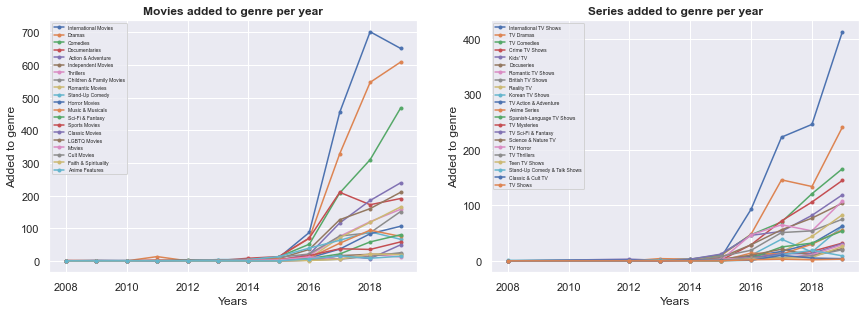

In [33]:
movieGenres = genresAddedPerYearMovies.index
seriesGenres = genresAddedPerYearSeries.index

fig, (ax1, ax2) = plt.subplots(1, 2, )
fig.subplots_adjust(right = 2, top = 1)

ax1.set_xlabel('Years')
ax1.set_ylabel('Added to genre')
ax1.set_title('Movies added to genre per year', fontweight = 'bold')

ax2.set_xlabel('Years')
ax2.set_ylabel('Added to genre')
ax2.set_title('Series added to genre per year', fontweight = 'bold')



for genre in movieGenres:
    ax1.plot(genresAddedPerYearMovies.loc[genre], marker = '.')

for genre in seriesGenres:
    ax2.plot(genresAddedPerYearSeries.loc[genre], marker = '.')

ax1.legend(movieGenres, loc = 2, fontsize = 5)
ax2.legend(seriesGenres, loc = 2, fontsize = 5)
plt.show()

We can tell from these two plots that the amount of new content added has been increasing every year, and the growth started to spike around 2015. We can also tell that there hasn't been added any new series in the years between 2008 and 2012. There are in total 11 movies/series missing a added date where 10 of them are series. Some of these, or all, might have been added in the years between 2008 and 2012, but we don't really know.

## Combinations of genres

In [34]:
def genreCombos(df: pd.DataFrame) -> pd.DataFrame:
        # Genre of every movie/series
    genres = correlation_between_genres.genresOfMoviesSeries(df)

    # How many occurences a genre needs to have to be included in the data
    TOTAL_OCCURENCE_THRESHOLD = 100

    # How many times a genre occurs
    genreOccurence = correlation_between_genres.totalOccurenceOfGenres(genres)

    # Only keeping genres that has an occurence higher than the threshold
    genreOccurence = genreOccurence[genreOccurence > TOTAL_OCCURENCE_THRESHOLD]

    # Cross-section between genres
    corrMatrix = pd.DataFrame(index = genreOccurence.keys(), columns = genreOccurence.keys())

    # Filling corrMatrix with values
    for genre1 in corrMatrix.keys():
        for genre2 in corrMatrix.keys():
            mainGenre = correlation_between_genres.moviesSeriesWithGenre(genres, genre1)
            genreCombination = correlation_between_genres.moviesSeriesWithGenre(mainGenre, genre2)

            if(genre1 == genre2):
                corrMatrix[genre1][genre2] = 0
            else:
                corrMatrix[genre1][genre2] = len(genreCombination)
                
    return corrMatrix

### Combination of genres in movies
NB! To show this plot open in JupyterLab.

In [35]:
moviesGenreCombos = genreCombos(dfMovies)

# Converts the cross-section matrix to a list as it is needed it the next step.
genreCombinationValues = moviesGenreCombos.values.tolist()
genreNames = moviesGenreCombos.index.tolist()

# NOTE: Requires to be run in jupyter lab as the plot won't show in notebook.
chord.Chord(genreCombinationValues, genreNames, margin=80, font_size_large='10px').show()

### Combination of genres in series
NB! To show this plot open in JupyterLab.

In [36]:
moviesGenreCombos = genreCombos(dfSeries)

# Converts the cross-section matrix to a list as it is needed it the next step.
genreCombinationValues = moviesGenreCombos.values.tolist()
genreNames = moviesGenreCombos.index.tolist()

# NOTE: Requires to be run in jupyter lab as the plot won't show in notebook.
chord.Chord(genreCombinationValues, genreNames, margin=80, font_size_large='10px').show()

## Patterns in genres

In this part, we wish to study how the catalogue changes per month over the various years. This is to identify (if there are) any patterns in the publication of new content. 

We start off by studying how the overall content is added to the catalogue:

In [37]:
#Start by making a copy of initial data_set:
df = data_set[["type","date_added"]].copy()


#We skip the rows where date_added is unknown,
#because these entries are irrelevant to the pattern of 
#content publication:
df = df[df.date_added != "Unknown date_added"]

#We know the current dataset:
df.head(10) #Only displaying top 10. 

,type,date_added
0,Movie,"September 9, 2019"
1,Movie,"September 9, 2016"
2,TV Show,"September 8, 2018"
3,TV Show,"September 8, 2018"
4,Movie,"September 8, 2017"
5,TV Show,"September 8, 2017"
6,Movie,"September 8, 2017"
7,Movie,"September 8, 2017"
8,TV Show,"September 8, 2017"
9,Movie,"September 8, 2017"


Since we wish to create a heatmap for months versus years for added content, we need to extract months and years from the date_added column. This is done by the apply() function \[1] and using lambda functions:

In [38]:
df["year"] = df["date_added"].apply(lambda x: x.split(", ")[-1])  #Lambda: Iterates though every entry. Splits by comma and extracts the last value (which is year)
df["month"] = df["date_added"].apply(lambda x: x.lstrip().split(" ")[0]) #Remove leading whitespace using lstrip(), then using split by whitespace and extracting the first value
df.head(10) #Display changes

,type,date_added,year,month
0,Movie,"September 9, 2019",2019,September
1,Movie,"September 9, 2016",2016,September
2,TV Show,"September 8, 2018",2018,September
3,TV Show,"September 8, 2018",2018,September
4,Movie,"September 8, 2017",2017,September
5,TV Show,"September 8, 2017",2017,September
6,Movie,"September 8, 2017",2017,September
7,Movie,"September 8, 2017",2017,September
8,TV Show,"September 8, 2017",2017,September
9,Movie,"September 8, 2017",2017,September


In order to make a heatmap, we convert the dataframe to a dataframe where the index are years and the columns are months. Then, we can count the number of times content is added per month and year:

In [39]:
df_grp = df.groupby("year") #Group dataframe by year to index it by years
df_grp = df_grp["month"].value_counts() #Counts unique values (year and month)
df_tab = df_grp.unstack() #Unstack to create a "tablezed" version of the dataframe. Source [https://riptutorial.com/pandas/example/6787/stacking-and-unstacking]
df_tab

month,April,August,December,February,January,July,June,March,May,November,October,September
year,,,,,,,,,,,,
2008,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN
2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,11.0,1.0
2012,NaN,1.0,1.0,1.0,NaN,2.0,NaN,NaN,NaN,1.0,1.0,NaN
2013,1.0,1.0,2.0,NaN,NaN,NaN,NaN,1.0,NaN,2.0,3.0,2.0
2014,2.0,1.0,6.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,4.0,1.0
2015,7.0,2.0,23.0,4.0,1.0,8.0,7.0,5.0,7.0,4.0,15.0,7.0
2016,23.0,44.0,98.0,16.0,44.0,31.0,19.0,19.0,14.0,47.0,53.0,48.0


Now we wish to replace NaNs by 0 and sort the columns by the months of the year:

In [40]:
df_tab = df_tab.fillna(0) #Fill NaNs with 0.

months = ["January","February","March","April","May","June","July",
         "August","September","October","November","December"]

df_tab = df_tab[months] #Sort colum by months
df_tab

month,January,February,March,April,May,June,July,August,September,October,November,December
year,,,,,,,,,,,,
2008,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2011,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,11.0,0.0,0.0
2012,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,1.0,1.0
2013,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,3.0,2.0,2.0
2014,2.0,2.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0,4.0,5.0,6.0
2015,1.0,4.0,5.0,7.0,7.0,7.0,8.0,2.0,7.0,15.0,4.0,23.0
2016,44.0,16.0,19.0,23.0,14.0,19.0,31.0,44.0,48.0,53.0,47.0,98.0


Finally, we may use this "tablelized" dataframe to plot a nice heatmap:

Text(0, 0.5, 'Year')

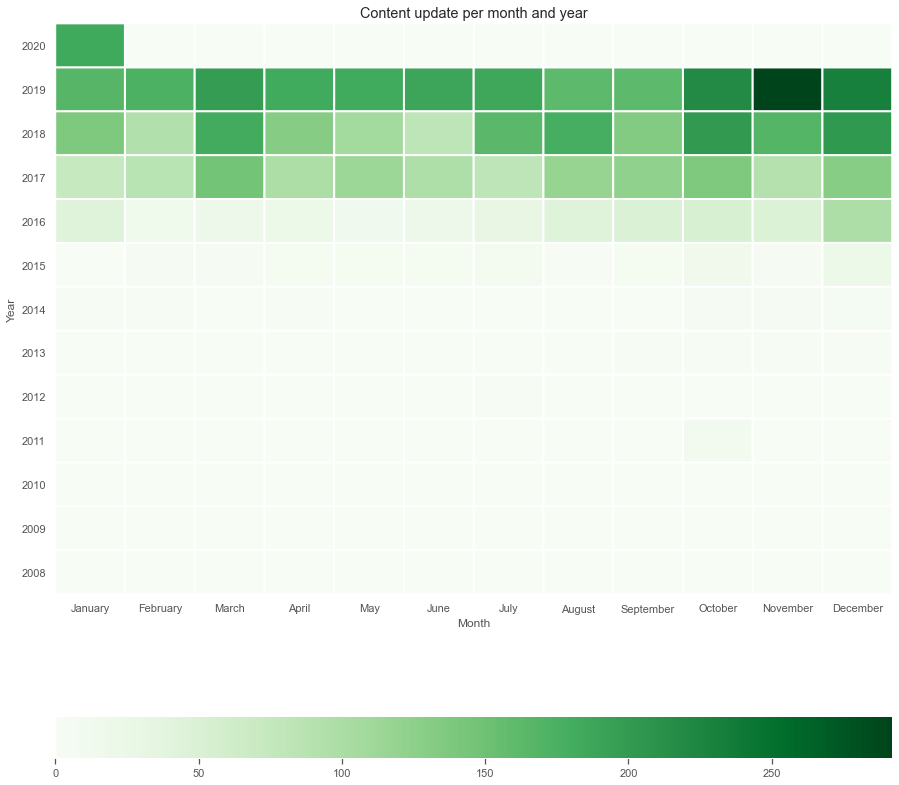

In [41]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(15,15))
plt.pcolor(df_tab, cmap="Greens", edgecolors = "white",linewidths=2) #Source: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.pcolor.html
plt.xticks(np.arange(0.5, len(df_tab.columns), 1), df_tab.columns) #Notice 0.5 to get months and years in middle of sqaures
plt.yticks(np.arange(0.5, len(df_tab.index), 1), df_tab.index)
plt.colorbar(orientation="horizontal") #Adds colorbar to the plot
plt.title("Content update per month and year")
plt.xlabel("Month")
plt.ylabel("Year")

We see that the amount of content update per month has been steadily increasing since the end of 2016. The figure also clearly indicated that November of 2019 was the month where the most contend were added. If the last total year of data (2019) is considered, we see that there less content beeing added in august and september. Therefore, adding data these months might increase the probability of success, as there is less competition among new content these months.

Now that we have an overall view of the added content on a per month basis, we can closer study when specific content is added to the catalogue.

The process above has been defined into functions in the yrs_months.py-file, so we only need to get a relevant dataframe and then the process  is done by the function heatplot_analysis(). 

C:\Users\ASLAKSK\study\dat540-netflix_catalogue\src\yrs_months.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["month"] = dataframe["date_added"].apply(lambda x: x.lstrip().split(" ")[0]) #Remove leading whitespace using lstrip(), then using split by whitespace and extracting the first value
C:\Users\ASLAKSK\study\dat540-netflix_catalogue\src\yrs_months.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["year"] = dataframe["date_added"].apply(lambda x: x.split(", ")[-1])  #Lambda:

month,January,February,March,April,May,June,July,August,September,October,November,December
year,,,,,,,,,,,,
2008,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2013,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0
2014,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0
2015,0.0,1.0,2.0,6.0,2.0,3.0,3.0,0.0,1.0,5.0,2.0,7.0
2016,29.0,7.0,4.0,8.0,5.0,8.0,12.0,19.0,19.0,19.0,18.0,44.0


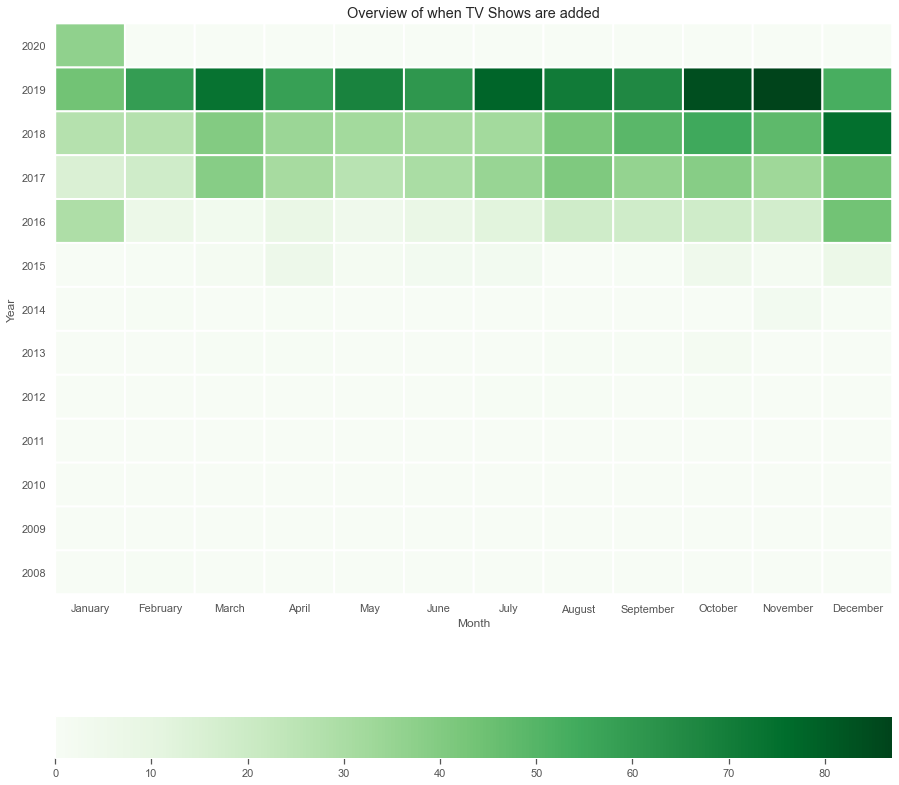

In [42]:
#Checking when TV Shows are added: 

df = data_set[["date_added","type"]].copy()
df_shows = df.loc[df["type"] == "TV Show"]

yrs_months.heatplot_analysis(df_shows,"Overview of when TV Shows are added","Month","Year")


We see that for TV Shows, there has been a steady increase in content starting in December 2016. The most TV Shows were added in December of 2019. The amount of content added during this month was over 100 titles, as seen from in the colorscheme. 

Now let us get an overview of when movies have been added:

C:\Users\ASLAKSK\study\dat540-netflix_catalogue\src\yrs_months.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["month"] = dataframe["date_added"].apply(lambda x: x.lstrip().split(" ")[0]) #Remove leading whitespace using lstrip(), then using split by whitespace and extracting the first value
C:\Users\ASLAKSK\study\dat540-netflix_catalogue\src\yrs_months.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["year"] = dataframe["date_added"].apply(lambda x: x.split(", ")[-1])  #Lambda:

month,January,February,March,April,May,June,July,August,September,October,November,December
year,,,,,,,,,,,,
2008,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2011,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,11.0,0.0,0.0
2012,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
2013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0
2014,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,4.0,2.0,5.0
2015,1.0,3.0,3.0,1.0,5.0,4.0,5.0,2.0,6.0,10.0,2.0,16.0
2016,15.0,9.0,15.0,15.0,9.0,11.0,19.0,25.0,29.0,34.0,29.0,54.0


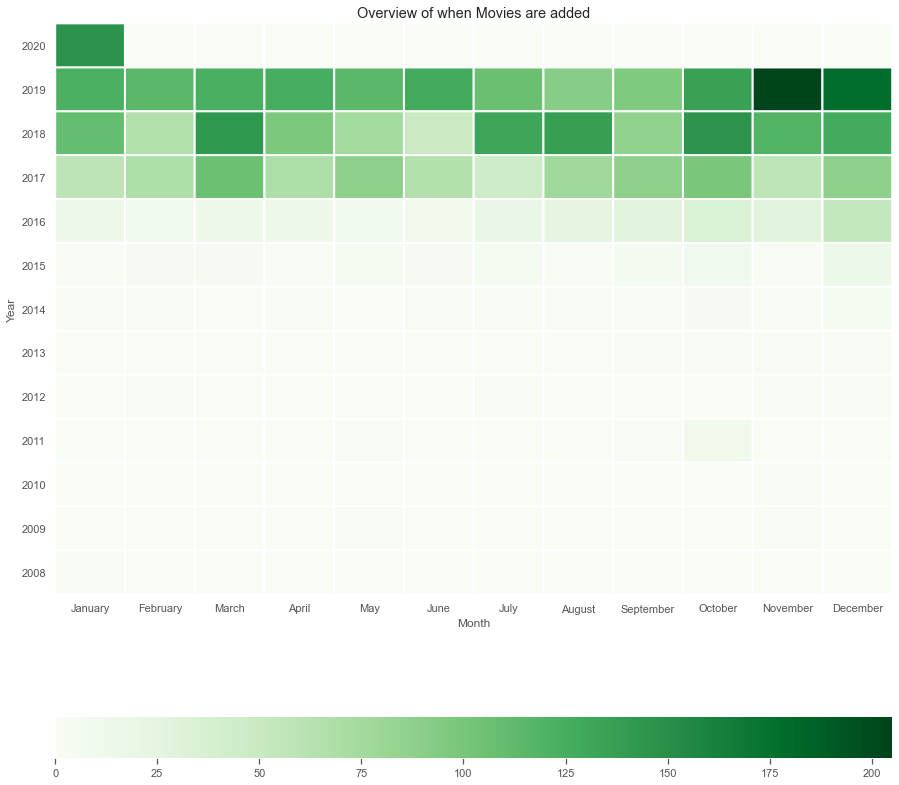

In [43]:
df_movie = df.loc[df["type"] == "Movie"]

yrs_months.heatplot_analysis(df_movie,"Overview of when Movies are added","Month","Year")

From the above figure, we see that November of 2019 was the month were most movies were added to the catalogue. This month, there where over 200 movie titles added. This is approximately twice as many movies added in Novembr 2019 compared to TV shows added in December 2019, which was the month most TV shows were added. This might be because it is easier to produce a movie compared to an enitre TV show. 

Now let us study some genre specific content and see if there are any patterns. 

The first place to start when determining if there are any seasonal patterns in the publication of conent is perhaps the most obvious: christmas content. Naturally, one might expect this content to be added to the catalogue towards christmas (november and december). 

Since Christmas is not a unique genre, we identify christmas movies by extracting all rows where the word "Christmas" is in the description column. 

month,January,February,March,April,May,June,July,August,September,October,November,December
year,,,,,,,,,,,,
2008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2016,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0


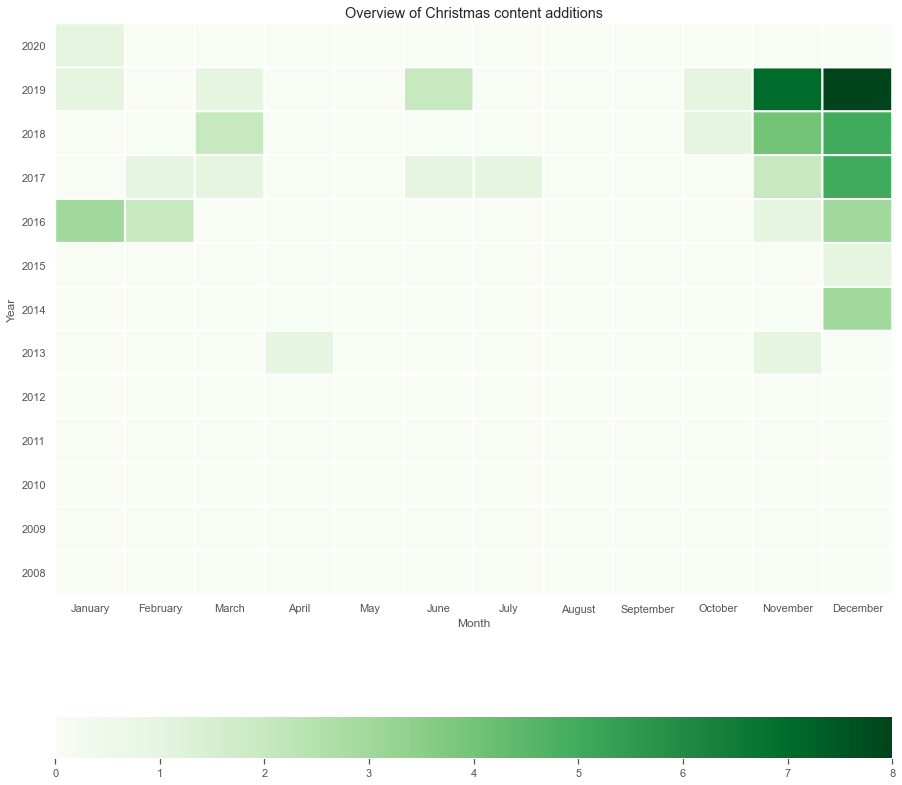

In [44]:
df_xmas = data_set[["date_added","description"]].copy()
df_xmas = df_xmas[df_xmas["description"].str.contains("Christmas")]
yrs_months.heatplot_analysis(df_xmas,"Overview of Christmas content additions","Month","Year")

As seen from the above plot, there is a clear pattern in when Christmas related content is added to the Netflix catalogue. We see that most Christmas content is added in November and December.

Another category that might containt some pattern is Horror, which one might expect to come out before Halloween. Therefore, we check for when Horrer content is added: 

month,January,February,March,April,May,June,July,August,September,October,November,December
year,,,,,,,,,,,,
2008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0
2016,0.0,0.0,1.0,2.0,1.0,0.0,2.0,1.0,2.0,1.0,1.0,3.0


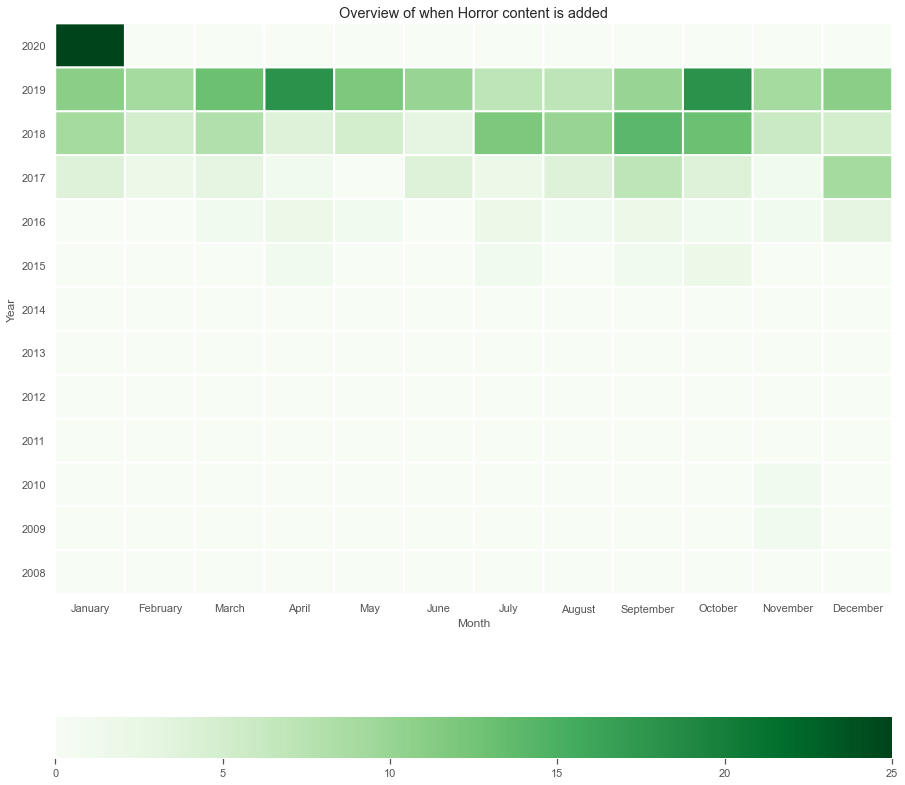

In [45]:
df_horror = data_set[["date_added","listed_in"]].copy()
df_horror = df_horror[df_horror["listed_in"].str.contains("Horror")]
yrs_months.heatplot_analysis(df_horror,"Overview of when Horror content is added","Month","Year")

We see that there is a large addition of Horror content (~25 titles) in January of 2020. Since the dataset stops at January 2020, it is difficult to make conclusions of the pattern of that specific year. By studying 2019, we see that May and October were two months when a significant amount of Horror relted content was added. For 2018, we see that September was the month with the most added Horror content. Thus, there is a weak pattern, but we cannot say definetly that Netflix adds more content before Halloween, as there were added large amounts in May 2019 and January 2020. 

Another category that might be of interest to study patterns in are love movies, and if there are any relation to the release of romantic movies around valentines:

month,January,February,March,April,May,June,July,August,September,October,November,December
year,,,,,,,,,,,,
2008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2016,0.0,2.0,2.0,0.0,2.0,1.0,1.0,8.0,7.0,9.0,8.0,15.0


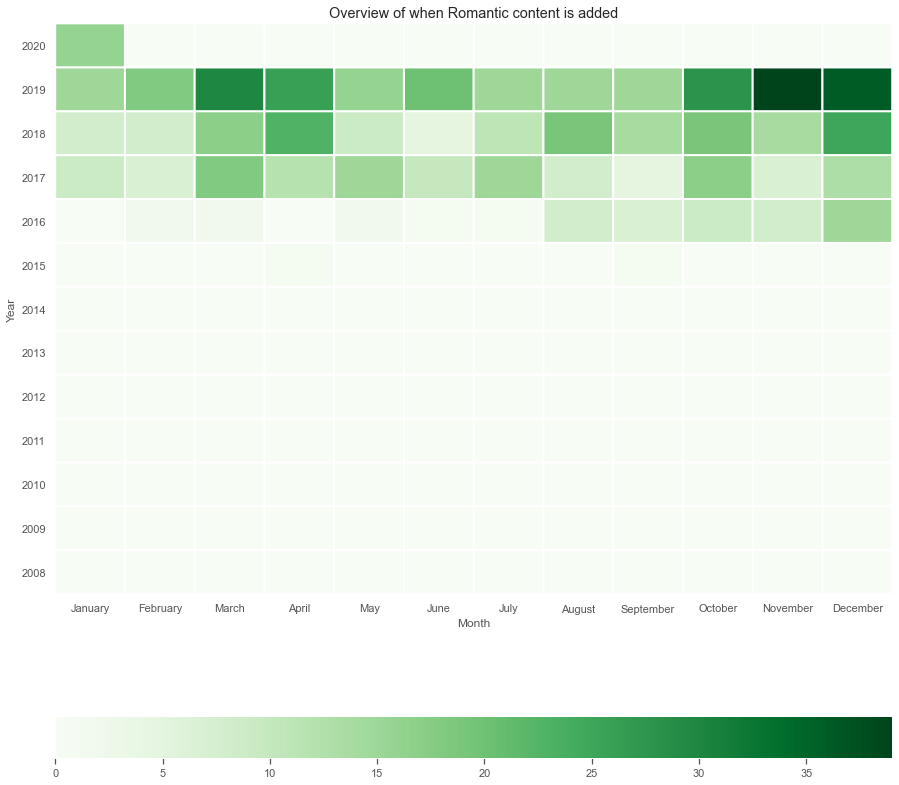

In [46]:
df_love = data_set[["date_added","listed_in"]].copy()
df_love = df_love[df_love["listed_in"].str.contains("Romantic")]
yrs_months.heatplot_analysis(df_love,"Overview of when Romantic content is added","Month","Year")

As can be seen form the above plot, there does not seem to be any relation between valentines day and the addition of Romantic content. 

Finally, we check to see if there are any relation between the addition of kids content and summer holiday and Christmas break: 

C:\Users\ASLAKSK\study\dat540-netflix_catalogue\src\yrs_months.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["month"] = dataframe["date_added"].apply(lambda x: x.lstrip().split(" ")[0]) #Remove leading whitespace using lstrip(), then using split by whitespace and extracting the first value
C:\Users\ASLAKSK\study\dat540-netflix_catalogue\src\yrs_months.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["year"] = dataframe["date_added"].apply(lambda x: x.split(", ")[-1])  #Lambda:

month,January,February,March,April,May,June,July,August,September,October,November,December
year,,,,,,,,,,,,
2008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2013,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
2015,0.0,0.0,1.0,0.0,2.0,3.0,1.0,0.0,0.0,2.0,1.0,2.0
2016,24.0,4.0,0.0,2.0,2.0,2.0,2.0,3.0,2.0,3.0,1.0,1.0


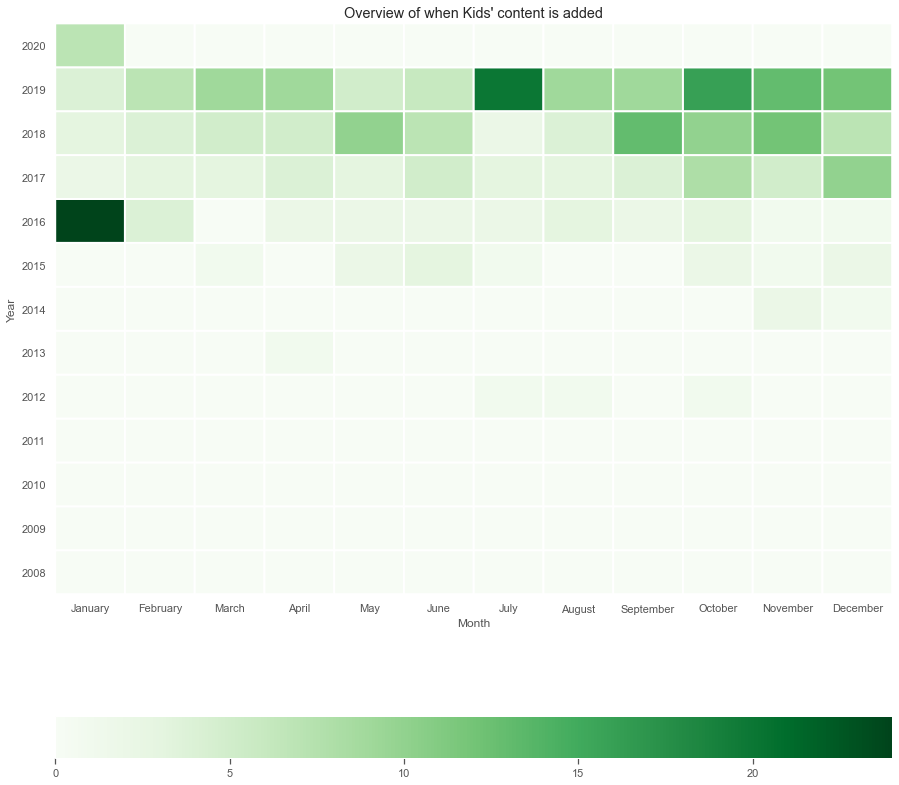

In [47]:
df_kids = data_set[["date_added","listed_in"]].copy()
df_kids = df_kids[df_kids["listed_in"].str.contains("Kids'")]
yrs_months.heatplot_analysis(df_kids,"Overview of when Kids' content is added","Month","Year")

In January of 2016, there was a large addition of kids' content to the catalogue. This is related to the fact that in January of 2016, Netflix announced that they would launch originals targeting kids \[4]. This is easily identified in the heatmap. There was a large addition of content in July 2019. However, none of the other years contain large summer releases, and we can therefore not conclude that there are any patterns in releasing content for kids around the summer holiday. For the period 2017-2019, if one compares the first half of the year (Jan-June) to the second half of the year (July-Dec), there seem to be more content coming out in the second half of the year. 

#### Sources for Patterns In Genres

\[1] pandas.DataFrame.apply [online]. Accessed 27/11/2020. avalable at < https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html >

\[2] Stacking and unstacking [online]. Accessed 28/11/2020. Available at < https://riptutorial.com/pandas/example/6787/stacking-and-unstacking >

\[3] matplotlib.pyplot.pcolor [online]. Accessed 29/11/2020. Available at < https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.pcolor.html >

\[4] Timeline of Netflix [online]. Accessed 06/12/2020. Available at < https://en.wikipedia.org/wiki/Timeline_of_Netflix >


# Summary genre

# Content evolution of Netflix.

<AxesSubplot:xlabel='release_year', ylabel='count'>

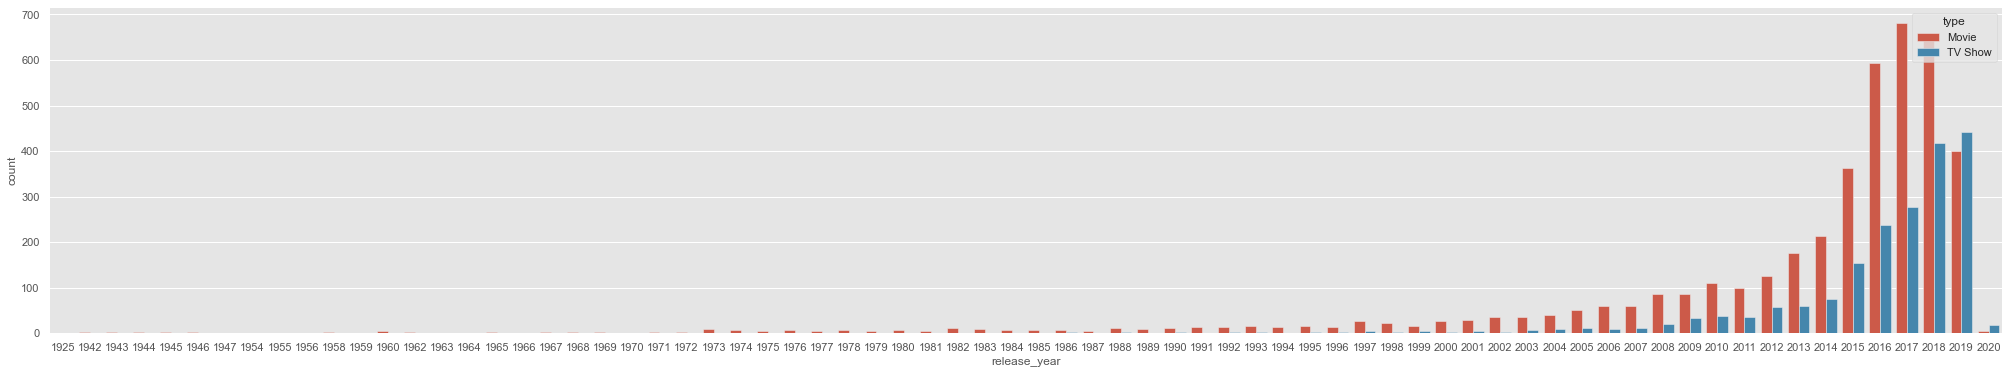

In [48]:
# Import the library used for plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (35,6))
sns.countplot(x='release_year', data = data_set, hue='type') # Plot the release year

<AxesSubplot:xlabel='year_added', ylabel='count'>

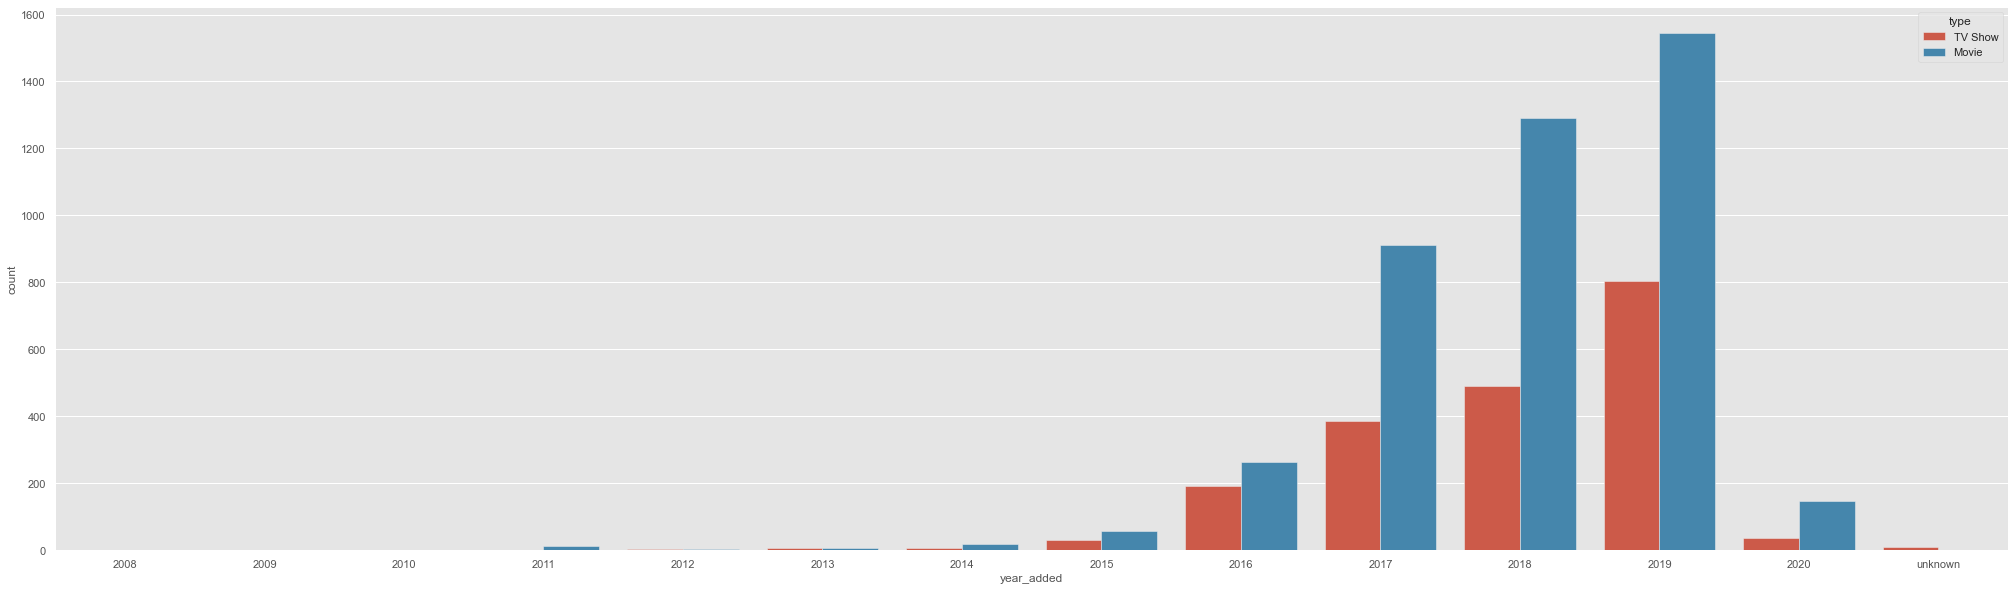

In [49]:
# See when series and movies where added to netflix catalouge
df = data_set.copy()
df['year_added'] = df['date_added'].str[-4:]
df['year_added'].replace({"dded": "unknown"}, inplace = True)
df.sort_values(by=['year_added'], inplace=True)

plt.figure(figsize = (35,10))
sns.countplot(x=df['year_added'], data = df, hue='type')


In [50]:
# Check when they added new and old content to the library

data_set['release_year'].value_counts()

2018    1063
2017     959
2019     843
2016     830
2015     517
        ... 
1959       1
1963       1
1964       1
1956       1
1925       1
Name: release_year, Length: 72, dtype: int64

<AxesSubplot:xlabel='year_added', ylabel='count'>

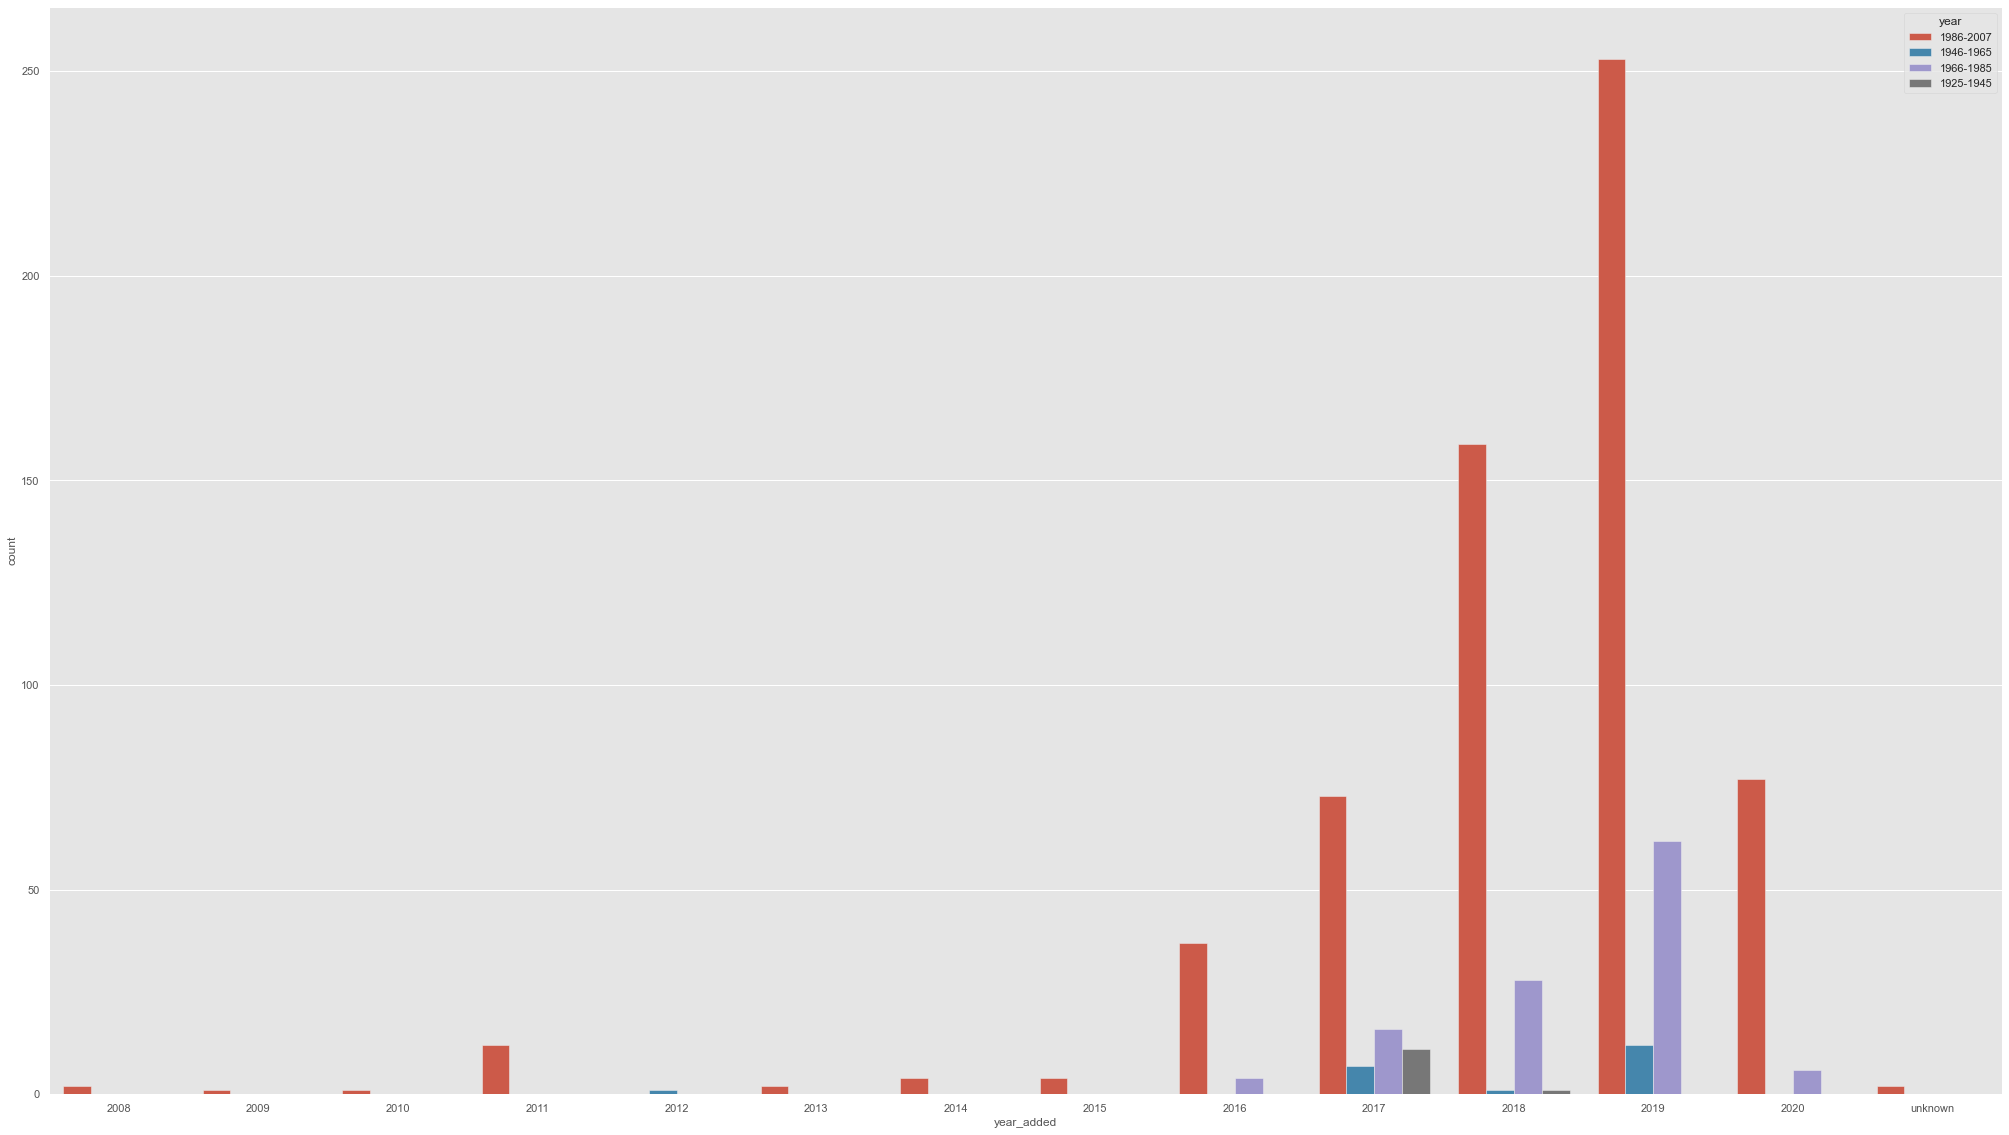

In [51]:
import numpy as np

# Ceck when netflix started to add older content to the catalouge

df['decade'] = ""   # Make new column in the dataset

# Make conditions for the plot
conditions = [
    (df['release_year'] >= 1925) & (df['release_year'] <= 1945),
    (df['release_year'] >= 1946) & (df['release_year'] <= 1965),
    (df['release_year'] >= 1966) & (df['release_year'] <= 1985),
    (df['release_year'] >= 1986) & (df['release_year'] <= 2007),
    (df['release_year'] >= 2008) & (df['release_year'] <= 2020)
]

values = ['1925-1945', '1946-1965', '1966-1985', '1986-2007', '2008-2020'] # Which value to add to the condition interval

df['year'] = np.select(conditions, values)   # Add values to decade

df.drop(df.loc[df['year']=='2008-2020'].index, inplace=True)  # Drop content made after netflixc was released


plt.figure(figsize = (35,20))
sns.countplot(x=df['year_added'], data = df, hue='year')



# Movie recommendations

The aim of this part is to create content recommondations based on a given title. 
In order to create recommondations, one needs to identify similarities between the given title and others titles in the dataset. 

The similarity between titles will be found by comparing and finding similarities in the description, genre and cast columns. 

To create recommondations, it is crucial to quantify the similarities. For this porpuse, the cosine similarity will be utlizied. The cosine similarity measures similarity between two vectors by comparing the angle between two vectors and determining if they are pointing in the same direction \[1]

To fully understand this concept before the developement of the recommendation system, a simple example is explained:

Consider two texts:

text1 = Hello Hello Goodbye

text2 = Goodbye Hello Goodbye

By identifying the words and their frequency in the two texts, the table below is acheived: 

|  | Hello | Goodbye |
| --- | --- | --- |
| textA | 2 | 1 |
| textB | 1 | 2 |

This can now be visualized as vectors: 


Text(0.5, 1.0, 'Vectorized representation of frequency of words')

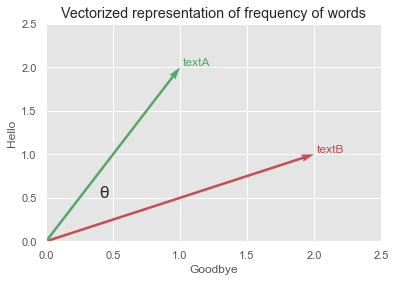

In [52]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
text1_occurences = [2,1]
text2_occurences = [1,2]
vectors = np.array([text1_occurences,text2_occurences])
origin = np.array([[0, 0],[0,0]])
plt.quiver(*origin,vectors[:,0],vectors[:,1],color=["r","g"],angles="xy",scale_units="xy",scale=1)
plt.xlim(0,2.5)
plt.ylim(0,2.5)
plt.xlabel("Goodbye")
plt.ylabel("Hello")
plt.text(0.4,0.5,"\u03B8",fontsize=17)
plt.text(1.02,2.02,"textA",fontsize=12,color="g")
plt.text(2.02,1.02,"textB",fontsize=12,color="r")
plt.title("Vectorized representation of frequency of words")


By letting $\theta$ be the angle between the two vectors, the cosine similarity  is calculated by: 
\begin{equation}
\cos \theta = \frac{A \cdot B}{ |A| \cdot |B|},
\end{equation}
where $A$ and $B$ are vectors representing the occurences of words in textA and textB, and $|A|$ and $|B|$ are the length of the vectors.
Recalling from calculus the relation between a cosine value for $\theta$ and the angle $\theta$ itself:

|  Degrees | cos $\theta$ |
|  --- | --- |
|  0 | 1 |
|  30 | 0.866 |
| 60 |  0.5 |
| 90 |  0 |

For this angle-identifying reason, the cosine similarity is used to identify similar content. The smaller the angle $\theta$ is between two vectors, the more similar the conent is. 

As mentioned above, the description, genre and cast column will be used to identify similarities. We start by extracting the dataframe with the respective columns:

In [ ]:
df = data_set[["title","description","listed_in","cast"]].copy()

In order to identify cosine similarities, we need to convert the information in the columns to strings. Therefore, the columns are modified and added to a seperate column. We start by removing stopwords from the description column and cleaning it up: 

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = stopwords.words('english')

In [ ]:
df

In [ ]:
#Clean the description column
df["description"] = df["description"].str.lower() #converting all words to lower 
df["description"] = df["description"].str.split() #creating each description to a list
df["description"] = df["description"].apply(lambda x: pd.Series(''.join([word + ' ' for word in x if word not in stop_words]))) #series of words not in stop words
df["description"] = df["description"].apply(lambda x: x.replace(',','')) #Removing commas
df["description"] = df["description"].apply(lambda x: x.replace('.','')) #Removing dots

In [ ]:
#Clean the listed in column
df["listed_in"] = df["listed_in"].str.lower()
df["listed_in"] = df["listed_in"].str.split()
df["listed_in"] = df["listed_in"].apply(lambda x: pd.Series(''.join([word + ' ' for word in x if word not in stop_words])))
df["listed_in"] = df["listed_in"].apply(lambda x: x.replace(',',''))
df["listed_in"] = df["listed_in"].apply(lambda x: x.replace('.',''))
df["listed_in"] = df["listed_in"].apply(lambda x: x.replace('&',''))

In [ ]:
#Clean the cast column
df["cast"] = df["cast"].str.lower()
df["cast"] = df["cast"].apply(lambda x: x.replace(' ','')) #removing whitespace between first and last name so cosine similraity checks entire actor name, and not only first name and last name
df["cast"] = df["cast"].apply(lambda x: x.replace(',',' ')) 



In [ ]:
#Combine description, listed_in and cast as new column 
df["all_info"] = df["description"] + df["listed_in"] + df["cast"]
#df.iloc[0].all_info run this line to see an example

In [ ]:
df

Now that we for each title have a single column containing information about the description, the genres and the cast, we can count instances of different words and create a matrix containing instances count of unique words. This can be acheived by using sklearn.feature_extraction.text.CountVectorizer, which is described to "convert a collection of text documents to a matrix of token counts" \[2].

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer() #Initialize a CountVectorizer object
count_matrix = cv.fit_transform(df["all_info"]) # Identify and count instances in the "all_info" column. 
# print(count_matrix.toarray()) print this line to get a feeling of what the count_matrix looks like

Once the count_matrix is acheived, the next step is to find the cosine similarity. For this purpose, sklearn.metrics.pairwise.cosine_similarity is used \[3].

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim = cosine_similarity(count_matrix) #Now the cosine similarities have been quantified
#print(cos_sim) print this line to get a feeling of what cosine sims looks like

#Defining two helper functions
def get_title_from_idx(df,idx):
    """
    Returns the title of a entry from a given index
    """
    return df[df.index == idx].title.values[0]
#df[df.index == index]["title"].values[0]

def get_idx_from_title(df,title):
    """
    Returns the index of a movie from a given title
    """
    return df[df["title"]==title].index.values.astype(int)[0]

In [ ]:
title_user_likes = "Transformers Prime" #Test code for transformers prime
title_idx = get_idx_from_title(df,title_user_likes) #identify the index of the title that the user likes

With the index of the movie, we can find the list of the cosine similarities for the specific title. This is done by:

In [ ]:
specific_cos_sim = cos_sim[title_idx]

We need to keep track of the indexes elements in the specific_cos_sim scores. By enumerating, the array of cosine similarity scores are converted into tuples containing the index and the scores. Finally, by converting these tuples into a list, we get a list of tuples containing the index and the scores:

In [ ]:
similar_content = list(enumerate(specific_cos_sim))

Now we wish to sort the list of tuples based on similarity scores. 

This is acheived by using the built-in sorted() function in python. The sorted() function buils a new list. In the official documentation for the sorted()-function, it says that the key should specify a function of one argument that is used to extract a comparison key for each element in the iterable \[4]. We wish to sort on second value for each tuple (wich is the cosine similirity score). I therefore define a function to acheive this:

In [ ]:
def key_func(val):
    return val[1]

sorted_similar = sorted(similar_content,key=key_func,reverse=True) #using reverse because we wish to sort by descending order
#note, could also have used key = lambda x: x[1]
sorted_similar_suggestions = sorted_similar[1:] #Skip the first because this will suggest itself


#Print top 5 similar content:
print("Most similar titles to "+ title_user_likes + " are:")
for e in sorted_similar_suggestions[0:5]:
    print(get_title_from_idx(df,e[0])) #As above, we have a list of tuples, where index 0 is key and inde 1 is cosine sim score. Therefore give index (e[0]) to function.
        

As seen from the above list, when entering Transformers Prime as liked content, the code returns content similar to this. This is specially noticeable as the top similar content is another Transformers movie, and we can therefore conclude that this recommondation system works fine. 

In [ ]:
#Defining the last part as a function and test a couple of times:

def title_recommender(df):
    user_likes_title = input("What title do you like? ")
    user_likes_idx = get_idx_from_title(df,user_likes_title)
    specific_cos_sim = cos_sim[user_likes_idx]
    similar_content = list(enumerate(specific_cos_sim))
    sorted_similar = sorted(similar_content,key=key_func,reverse=True)[1:]
    print("Most similar titles to "+ user_likes_title + " are:")
    for e in sorted_similar[0:5]:
        print(get_title_from_idx(df,e[0])) 

In [ ]:
title_recommender(df) #Enter "Breaking Bad"

We see that one of the suggestions for Breaking Bad is Better Call Saul. This verify the code that the implementation works well, as the two TV shows are related. 

#### Sources for Movie recommendation part

\[1] Kamber, M., Han, J. & Pei, J. Data Mining (Third Edition), p.39-81 [online]. Accessed 03/12/20. Available at < https://www.sciencedirect.com/science/article/pii/B9780123814791000022 >

\[2] sklearn.feature_extraction.text.CountVectorizer [online]. Accessed 03/12/20. Available at < https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html >

\[3] sklearn.metrics.pairwise.cosine_similarity [online]. Accessed 04/12/20. Available at < https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html >

\[4] Python Built-In Functions [online]. Accessed 05/12/20. Available at < https://docs.python.org/3/library/functions.html#sorted >


# Neural Network

Ex 4. Try to predict the genre of a movie/show based on the director, actors, etc. using
machine/deep learning techniques.

Here we take a dive into a Neural Network model. It was decided to use the model [MLPClassifier][MLPClassifier] from the sklearn library. We will start this chapter with some displamers. 

Only the finalized model will be displayed here. The data has been polished the python file _cleaning_data_for_NN.py_ to improve the final product. The changes has been mainly to combine similar genres and to remove names of actor/actresses that were only displayed once in the dataset. We believed this would improve our model. 

As stated, the model has been ran several times, however, only the final model has been displayed below.Furthermore, the previous model has been saved and their report is located below in the [result](#Results) section.


## Programming Logic

The core of the programming logic for the final model is simple. In the _cleaning_data_for_NN.py_ file we start by cleaning the provided [netflix data][netflixData] set. Removing nan values and values that were incoherent. Movies/TV Shows labled _just_ Movies/TV Shows were dropped from the dataset, and genres labeled with "TV Show" or "Movie", as for example Romantic Movies ( or Romantic TV Shows) were renamed to just Romantic. The main reason were try to improve the amount of datapoints with the same genre and reducing the amount of classes in the output data. 

Afterwards the data were checked for duplicates. We had issues with some lables because they were mentioned twice in a row. The biggest issue were about "International Movies/TV Shows". Our decision to combine all International subject to a larger genre called "International" made it often appeared more than once in several row it was a subject of. We decided to remove duplicates and the Pandas Dataframe were saved to another CSV file, called _cleaned_Netflix_for_NN.csv_.

[MLPClassifier]: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
[netflixData]: https://www.kaggle.com/shivamb/netflix-shows

### Reading of CSV file, creating and transforming X & y data.

The file _final_NN_script.py_ contains the logic of the final Neural Network algorithm. It will be presented in parts below.

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import pickle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction import text 
from sklearn.metrics import classification_report, multilabel_confusion_matrix

In [54]:
netflix_data=pd.read_csv("cleaned_Netflix_for_NN.csv")

smaller_data = netflix_data.copy()

y = smaller_data.listed_in
X = [','.join((d, c, r, t)) for d,c,r,t in zip(
                                                smaller_data.director, 
                                                smaller_data.cast, 
                                                smaller_data.rating, 
                                                smaller_data.title
                                            )]

# Custom stop words for the CountVectorizer to ignore while transforming.
customStopWords=['no cast', 'no director', 'movies', 'tv shows',
                'lgbtq movies', 'teen tv shows', 'cult'] 

# Find all actors that only appears once in the dataset
customCastStopWords = smaller_data.cast.str.split(', ').explode().value_counts()[
    smaller_data.cast.str.split(', ').explode().value_counts() < 2].keys()
customCastStopWords = [x.lower() for x in customCastStopWords] # Make all values lowercase

# Add stopwords for vectorizer into single frozenset
stop_words = text.ENGLISH_STOP_WORDS.union(customStopWords)
stop_words = stop_words.union(list(customCastStopWords))

# Split data into train and test data, training data = 80% of original data & test = 20%.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1000) 

# Define the vectorizer algorithm
matrix = CountVectorizer(
    tokenizer=lambda row: [x.strip() for x in row.split(',') if x != ''], 
    stop_words=stop_words)

# Transform X data
x_train_fit = matrix.fit_transform(X_train)
x_test_fit = matrix.transform(X_test)

# Transform y data
y_train_fit = matrix.fit_transform(y_train)
y_test_fit = matrix.transform(y_test)

# Printing out all genres in the y data
print("Genres:")
for i in matrix.get_feature_names():
    print(i)

Genres:
action & adventure
anime
british tv shows
classic
comedies
crime
documentaries
dramas
faith & spirituality
horror
independent movies
international
kids
music & musicals
mysteries
reality tv
romantic
sci-fi & fantasy
science & nature tv
spanish-language tv shows
sports movies
thrillers


C:\Users\ASLAKSK\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['jr.'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


#### X & y data

A few lines needs to be explained in the code section above. The fist is the making of the Y and X data (out and in data) used by the Neural Network algorithm. 
```python
y = smaller_data.listed_in
X = [','.join((d, c, r, t)) for d,c,r,t in zip(
                                                smaller_data.director, 
                                                smaller_data.cast, 
                                                smaller_data.rating, 
                                                smaller_data.title
                                            )]
```

y data is the output prediction, and in this model we are trying to predict genres from numerous columns of the data set. Alittle selfexplanatory that the y (out) data points needs to be the genres, which, in the dataset is called _listed_in_

The X data has a simple ( and potentionally improved ) python _join_ method implementation. We make use of the _CountVectorizer_ method deployed by the sklearn library. This will be further explained later, now we just need to know the input of this can be either a string or byte. 

[From the countVectorizer documentation][countVectorizer]: 
> input : string {‘filename’, ‘file’, ‘content’}, default=’content’ <br>
> _Otherwise the input is expected to be a sequence of items that can be of type string or byte._

To get around this issue (easily) since we want several columns the join method were implemented. Here, for each row, we join all directors, cast members, the rating and the tile into single list of string. This is discussed in the [Improvment Chapter](#Improvments-and-further-research)

[countVectorizer]: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

#### Stopwords

The next section explained is the stopword logic. Because the netflix data set has empty cells from nearly each column, we made use of the imputation method explained earlier and replaces the empty words with filler words as _No Director_ or _No Cast_. Because these words is selfmade and has no meaning, they needs to not be counted by the CountVectorizer method. Here the stopwords come into play. By writing _No Director_ or _No Cast_ as stopwords (among others), we can rely on the method to not take these words into account when making the fitted data.


```python
# Custom stop words for the CountVectorizer to ignore while transforming.
customStopWords=['no cast', 'no director', 'movies', 'tv shows',
                'lgbtq movies', 'teen tv shows', 'cult'] 

customCastStopWords = smaller_data.cast.str.split(', ').explode().value_counts()[
    smaller_data.cast.str.split(', ').explode().value_counts() < 2].keys()
                                                                                 
customCastStopWords = [x.lower() for x in customCastStopWords] # Make all values lowercase

# Add stopwords for vectorizer into single frozenset
stop_words = text.ENGLISH_STOP_WORDS.union(customStopWords)
stop_words = stop_words.union(list(customCastStopWords))
```

This section of code creates the stopwords for the final model. From previous test the ``` 'lgbtq movies', 'teen tv shows', 'cult' ``` values were added to the stopwords due to the results from the [Classification Report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) from a previous model. 
Further it was decided to remove all actors that only appeared in one movie. The variable _customCastStopWords_ stores these values. 

#### CountVectorizer

After splitting the data into both test and train datasets with a ratio of 20 to 80 percent of the original dataset, the CountVectorizer is used. The documentation explains the class from sklearn as this: 
> Convert a collection of text documents to a matrix of token counts

The method is implemented with a lamdba function: ```  tokenizer=lambda row: [x.strip() for x in row.split(',') if x != ''] ``` The tokenizer paramter is explained as such: 
> tokenizer : callable, default=None <br>
Override the string tokenization step while preserving the preprocessing and n-grams generation steps. 

This is the parameter that is used to split the words from each row. The lamdba function has been implemented to make use of the join method used to join all the different columns. Now each row gets split and stripped for whitespaces to make sure that every item is the same.  

### MLPClassifier method

In [55]:
hidden_layer = 1000 #round(x_train_fit.shape[1]*(2/3) + y_train_fit.shape[1])

# Small datetime to check when ML started
datetime_object = datetime.datetime.now()
print("Begin ML: ", datetime_object)

# Neural Network algorithm
clf = MLPClassifier(hidden_layer_sizes=(hidden_layer,hidden_layer ),
                    solver='adam', verbose=True, 
                    random_state=1, max_iter=50) 

clf.fit(x_train_fit, y_train_fit)

# Small datetime to check when ML stopped
datetime_object = datetime.datetime.now()
print("End ML: ", datetime_object)

Begin ML:  2020-12-06 19:08:08.042513
Iteration 1, loss = 8.33889869
Iteration 2, loss = 5.50173792
End ML:  2020-12-06 19:08:44.500438


C:\Users\ASLAKSK\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


## Results

As this defined as a unbalanced multilabeled classification, we can look at the micro average results to best see the results of the NN model.
By having the _drama_ genre as an example: 

Precision is calculated: <br>
drama correctly indentified divided by drama correctly identified plus other genres identified as drama

Recall is calculated:
Drama correctly identified by drama correctly identified plus drama identified as other genres. 
##### First model

First we present the Classification Report of the First model



In [56]:
from first_NN_model import first_NN_model

x_train_fit, x_test_fit, y_train_fit, y_test_fit, matrix = first_NN_model()

fileName = 'first_unflitered_NN_model.sav'

loaded_model = pickle.load(open(fileName, 'rb'))
y_pred = loaded_model.predict(x_test_fit)


print("Classification Report: \n", classification_report(y_test_fit,y_pred, target_names=list(matrix.get_feature_names())))


FileNotFoundError: [Errno 2] No such file or directory: 'first_unflitered_NN_model.sav'

Before cleaning up the data we can still see a good precision score, however the recall score is lower. 

#### Improving genre data

The first attempt to improve the results were to redefine genres. Previous report says several genres had a precision and recall score of 0, thus we made the decision to combine the genres and/or removed them from the transformed dataset. The resulting report is seen below.

In [ ]:
from cleaned_genres_script import cleaned_genres_NN_model

x_train_fit, x_test_fit, y_train_fit, y_test_fit, matrix = cleaned_genres_NN_model()

fileName = 'cleaned_genres_NN_model.sav'

loaded_model = pickle.load(open(fileName, 'rb'))
y_pred = loaded_model.predict(x_test_fit)


print("Classification Report: \n", classification_report(y_test_fit,y_pred, target_names=list(matrix.get_feature_names())))


The result shows a good improvment from 0.19 to 0.38 when we cleaned the genres up. We halved the amount of genres from 42  to 22. Our hypothesis to get more refined genres had a positiv result. However, we can still try to get better results. 

#### Final result

The final model removed all actors that only appeared in one movie, (approx 20k names). The logic is seen in the [first subchapter of Programming Logic](#Reading-of-CSV-file,-creating-and-transforming-X-&-y-data.) chapter. We assumed that these names would only confuse the model and not be helpful. The results are printed below in the already saved model.

In [ ]:
# Import values needed for classification report
from final_NN_script import final_NN_model

x_train_fit, x_test_fit, y_train_fit, y_test_fit, matrix = final_NN_model()
# Compute results
fileName = 'Final_NN_model.sav'

loaded_model = pickle.load(open(fileName, 'rb'))
y_pred = loaded_model.predict(x_test_fit)


print("Classification Report: \n", classification_report(y_test_fit,y_pred, target_names=list(matrix.get_feature_names())))


Here we actually see an further improvment on the recall and a small reduction in the precision. Can further small adjustments improve the model? 

### Confusion Matrix Visualization

In [ ]:
# Confusion Matrix
cm = multilabel_confusion_matrix(y_test_fit, y_pred)

# Make labels out of genres
labels = matrix.get_feature_names()
 
def mutlilabel_cm_plot(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_xlabel('True label')
    axes.set_ylabel('Predicted label')
    axes.set_title(class_label)
    
# Plot Confusion Matrix
fig, ax = plt.subplots(6, 4, figsize=(7, 12))
    
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
    mutlilabel_cm_plot(cfs_matrix, axes, label, ["Y", "N"])

fig.tight_layout()
plt.show()

At the end we show the confusion matrixes of all the genres from the final model. 

### Improvments and further research

Here arqe some features that could have been improved given more knowledge and time

#### Questions
* Could a word embedding model be used to further generalize the names of actor/actresses? 
* Could the title be used in a better extend? Maybe split and remove more of the same word and not use whole title string as an node?
* Could word embedding be used to generelize the training/test data better than the manuall cleaning?

#### Improvments
* The model could be more refined to accept functions and/or make it more resuable.
* The cleaning could be refined to accept different datasets, the genre that were changed is now hardcoded in a dictonary. This is not optimal. 

# Preparing data for machine learning

In [ ]:
import pandas as pd
import numpy as np
import data_sanitizer
import matplotlib.pyplot as plt

dataSet = pd.read_csv('../netflix_titles.csv')

In [ ]:
dataSet = pd.read_csv('../netflix_titles.csv')
# Copy listed_in column into it's own dataframe, split each genre into it's own columns and rename the columns
genres = dataSet['listed_in'].str.split(', ', expand=True)
genres.rename(columns = {0: 'genre1', 1: 'genre2', 2: 'genre3'}, inplace = True)
genres

In [ ]:
# Do the same as above for cast and director columns
cast = dataSet['cast'].str.split(', ', expand = True)
director = dataSet['director'].str.split(', ', expand = True)

for i in cast.keys():
    cast.rename(columns={i: 'actor{}'.format(i + 1)}, inplace = True)

for i in director.keys():
    director.rename(columns={i: 'director{}'.format(i + 1)}, inplace = True)

cast

In [ ]:
# Remove International Movies and International TV Shows from genres as it is overrepresented and doesn't really tell us much

genres = genres.replace({'International Movies': None})
genres = genres.replace({'International TV Shows': None})

In [ ]:
# Set any cell that doesn't have a value to nan
director = director[director.notnull()]
cast = cast[cast.notnull()]
genres = genres[genres.notnull()]
genres

In [ ]:
# Fetch how many times each director occurs in movies and series
directorOccurence = pd.Series()

for col in director:
    count = director[col].value_counts()
    directorOccurence = directorOccurence.add(count, fill_value = 0)

directorOccurence = directorOccurence.sort_values(ascending=False)

# Which directors occur in more than 7 movies and series
directorOccurence[directorOccurence > 7]

In [ ]:
# Same as above but for actors instead
actorOccurence = pd.Series()

for col in cast:
    count = cast[col].value_counts()
    actorOccurence = actorOccurence.add(count, fill_value = 0)

actorOccurence = actorOccurence.sort_values(ascending=False)

# Actors that occur in more than 2 movies and series
actorOccurence
actorOccurence[actorOccurence > 2]

In [ ]:
cast.count()
# We can tell from this that there are very few data entries in the columns further out and we choose to drop
# these as there won't be much information lost compared to the potential gain in memory saved.

In [ ]:
# Only want to keep columns with more than 100 data points

# Potential problem with this approach is that we could lose informtion on the same actor in the case where an actor always occurs as one of the last everytime
cast = cast[cast.count().keys()[cast.count().values > 100]]
cast

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.subplots_adjust(right = 3, top = 2)

# Plot comparing the directors who occurs the most.
directorsTop = directorOccurence.iloc[0:50].sort_values()

ax1.set_title('Top 50 directors by occurance', fontweight = 'bold')
ax1.set_xlabel('Occurance')
ax1.barh(width = directorsTop.values, y = directorsTop.keys())

# Plot comparing the actors who occurs the most.
actorsTop = actorOccurence.iloc[0:50].sort_values()

ax2.set_title('Top 50 actors by occurance', fontweight = 'bold')
ax2.set_xlabel('Occurance')
ax2.barh(width = actorsTop.values, y = actorsTop.keys())

fig.show()

In [ ]:
# Check if there is any common genres the directors occur in.

# Set to any value between 0 and 50 where 50 is the director with the highest occurance
DIRECTOR_INDEX = 25

director_with_highest_occurance = directorsTop.index[DIRECTOR_INDEX]

movies_series_director_occurs_indexes = []

for col in director.columns:
    movies_series_director_occurs_indexes += director.loc[director[col] == director_with_highest_occurance].index.values.tolist()


genres.iloc[movies_series_director_occurs_indexes]

# We can tell from this that there actually seems to be a really big correlation between director and genres (at least for the top 25) as a director
# keeps making movies/series in the same genres.

In [ ]:
# Check if there is any common genres the actors occur in.

# Set to any value between 0 and 50 where 50 is the actor with the highest occurance
ACTOR_INDEX = 25

actor_with_highest_occurance = actorsTop.index[ACTOR_INDEX]

movies_series_actor_occurs_indexes = []



for col in cast.columns:
    movies_series_actor_occurs_indexes += cast.loc[cast[col] == actor_with_highest_occurance].index.values.tolist()


genres.iloc[movies_series_actor_occurs_indexes]

# There seems to be some correlation between an actor and genres as well, but not as strong as with the directors. As
# many of the actors do occur in the same genres multiple times, but they also deviate from their "main genre" at times.

This relationship between directors and genres, and actors and genres, can be used to predict the genre of a movie based on director and actor, but we got an issue that the number of movies/series an actor/director has been a part of drops of quickly as we can tell from the occurance plots. This means that if we would want to use this information to create a model using machine learning, it could become hard to get a model with high accuracy if what we input to the model doesn't contain any of the directors or actors that has a high occurance, and there isn't particulary many of them.

In [2]:
from IPython.display import Image

# Predict genre from title and description
## In this section we are trying to predict genre from the two columns "title" and "description"
### The metedology is:

- Import libraries neeeded to make a suitable model and dataset for the model
- Clean up the information in the required columns in the dataframe
- Find the frequency of all the words used in title and description and remove the common stop words from the english language
- Set up a multi label binarizer which is a binary vector representing all genres
- Set up a logistic regression model to run the dataset 
- Use the one vs rest classifier to test each word against the binary vector of genres
- The goal is to link the most common words to a genre and be able to predict the genre from the description

## Why multilabel?

The target value we are testing is genre. Each movie can have several genres and we therefor need a model that can check the input towards several target values. Below is the common 1 vs 1 input to the model and target value represented on the left side. From our data we can have several genres and need a model as shown in the 1 vs multiple targets table.  

![title](multilabel.png)


In [3]:
# import packages needed for data analysis and visialization
from matplotlib import pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns
import re
import nltk

### Explore data set - genres
The Netflix catalogue has a total of 42 unique genres. The number of movies or TV shows in each genres vary a lot and ranges from 1927 movies in the "International Movies" category to only 10 entries in the "TV Shows" category. We see that a few genres are over represented in both the movie and TV show section and a lot of genres have a limited number of entries. The visualization section earlier in the notebook shows more of the distribution of the genres. 

Due to the relatively short data set and the large number of genres we see that we will have to modify the data set to get more accurate predictions. We ran the method in the end of this section on the full dataset (all genres and types) and will later compare these results to the final results, this to justify some of the choices that were made in the process of cleaning the dataset. 

In [4]:
# Lets check all the unique genres we have in the dataset and the count.
movie_genres = data_set['listed_in'].loc[data_set['type'] == 'Movie'].str.split(', ').explode().value_counts()
tvshow_genres = data_set['listed_in'].loc[data_set['type'] == 'TV Show'].str.split(', ').explode().value_counts()

print(movie_genres)
print(tvshow_genres)

International Movies        1927
Dramas                      1623
Comedies                    1113
Documentaries                668
Action & Adventure           597
Independent Movies           552
Thrillers                    392
Children & Family Movies     378
Romantic Movies              376
Stand-Up Comedy              281
Horror Movies                262
Music & Musicals             243
Sci-Fi & Fantasy             193
Sports Movies                157
Classic Movies                84
LGBTQ Movies                  60
Movies                        56
Cult Movies                   55
Faith & Spirituality          47
Anime Features                45
Name: listed_in, dtype: int64
International TV Shows          1001
TV Dramas                        599
TV Comedies                      436
Crime TV Shows                   363
Kids' TV                         328
Docuseries                       279
Romantic TV Shows                278
British TV Shows                 210
Reality TV    

## Cleaning the dataset

First we make a copy of the data set to start to prepare the data as input. It was decided to only use the Movies type for this exercise as this will still give us a large amount of data as there are 4265 movies in the data set. This will also eliminate 22 genres and leave us with 20 genres.

In [5]:
# create new data set with only type = Movie
new_set = data_set[data_set['type'] == 'Movie'].copy()

# Split genres into list
new_set['genre'] = new_set['listed_in'].apply(lambda x: x.split(', '))

#Total no. of movies:
print(f"Total no. of Movies in the data set: {new_set.shape[0]}")

Total no. of Movies in the data set: 4265


First we have to clean the data set to be able to input it in the functions later in this section. We will use the title and description columns to try to predict the genres. The method we use count the number of occurences of the words in the title and description and relate it to the genre of the movie. To be make sure that all equal words get counted we clean the data set by:
- making everything lower case
- remove all symbols and only keep letters from the English alphabet
- remove whitespaces

This is done using the clean_text() function on the columns "title" and "description". Then we added the title and description columns together as one text.

In [6]:
# function for text cleaning 
def clean_text(text):
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

# Clean each description and title using clean_text function
new_set['clean_desc'] = new_set['description'].apply(lambda x: clean_text(x))
new_set['clean_title'] = new_set['title'].apply(lambda x: clean_text(x))

# add title to description
new_set['title_description'] = new_set['clean_title'] + str(" ") + new_set['clean_desc']

From running the model with all genres, we saw that the categories with very few movies gave really poor results. It was therefore decided to remove the 8 least frequent genres (Anime to Sci-Fi & Fantasy in the list above). This was done by renaming them "Other", removing the lines where "Other" was the only genre and removing the rest of the "Other" category from the other movies. This left a data set that still has at least one genre per movie, but we have eliminated most of the genres that would have caused "noise" in the results. With this we end up with 12 unique genres.

In [7]:
# List of 8 genres with the least no. of movies
rare_genres = data_set[data_set.type=="Movie"].listed_in.str.split(', ').explode().value_counts().index[-8:]

# Rename the 8 rare genres above with "Other"
new_set['genre'] = new_set.genre.apply(lambda x: ["Other" if np.isin(y, rare_genres) else y for y in x])
# Remove "Other" from the data set
new_set = new_set[new_set.genre != "Other"]
new_set['genre'] = (new_set.genre.map(set)-{'Other'}).map(list)

## Find the frequency the words are apperaing in the data set
First we take a look at the data set and the most frequent words in the title and description of the dataset. We plot this to get an idea if these can be used to predict the genres. We see that the most frequent words are as expected short words used to connect sentences, such as "a", "the" and "to". These will be used in all categories and will not help to identify the genre of the movie.

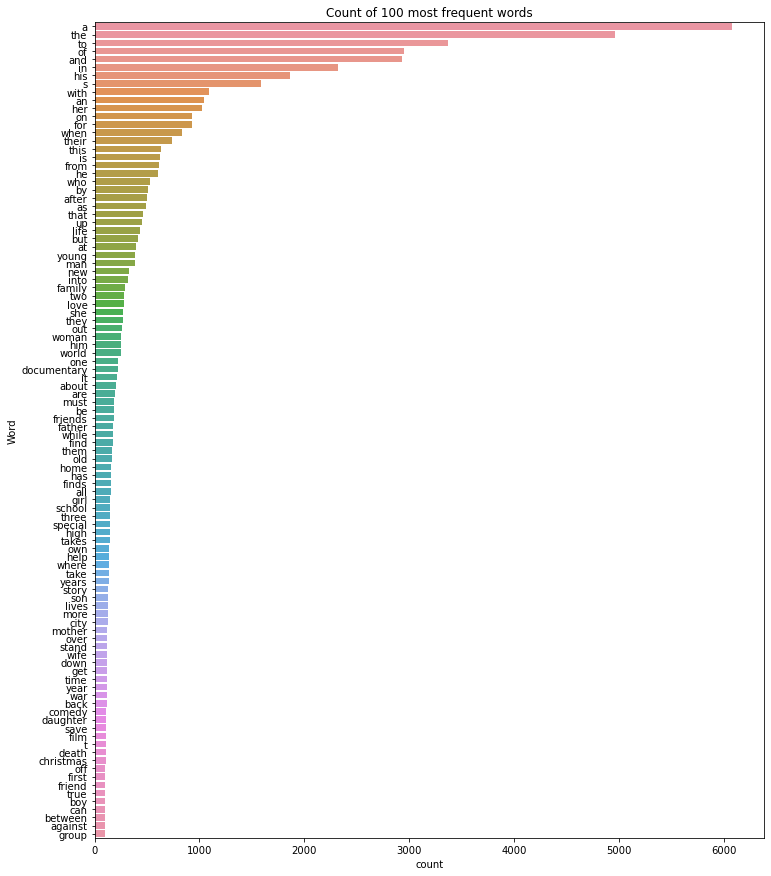

In [8]:
def freq_words(text, terms = 30): 
  # Create word list from all words in title and description in pandas series
  words = text.str.split(expand=True).stack()
  
  # selecting top n most frequent words in order
  d = words.value_counts().index[:terms]
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.countplot(y=words, order=d)
  ax.set(ylabel = 'Word') 
  ax.set_title(f"Count of {terms} most frequent words")
  plt.show()
  
# print 100 most frequent words 
freq_words(new_set['title_description'], 100)

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASLAKSK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Remove all the stop words from the dataset

As mentioned above, we see that the most common words un the dataset are typically "a", "the", "to", etc. These common words will not give any value in predicting the genres. Stop words are the most common words in the English language, a list of these can be used to remove these words in the data set. A common way to remove stop words is to import the library stopwords from nltk.corpus. <br>
A good solution to remove stop words was found at. https://www.geeksforgeeks.org/removing-stop-words-nltk-python/


In [10]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

new_set['title_description'] = new_set['title_description'].apply(lambda x: remove_stopwords(x))

The new most frequent words after removing stopwords have been plotted below. We see that we now have words that could potentially represent cretain genres. 

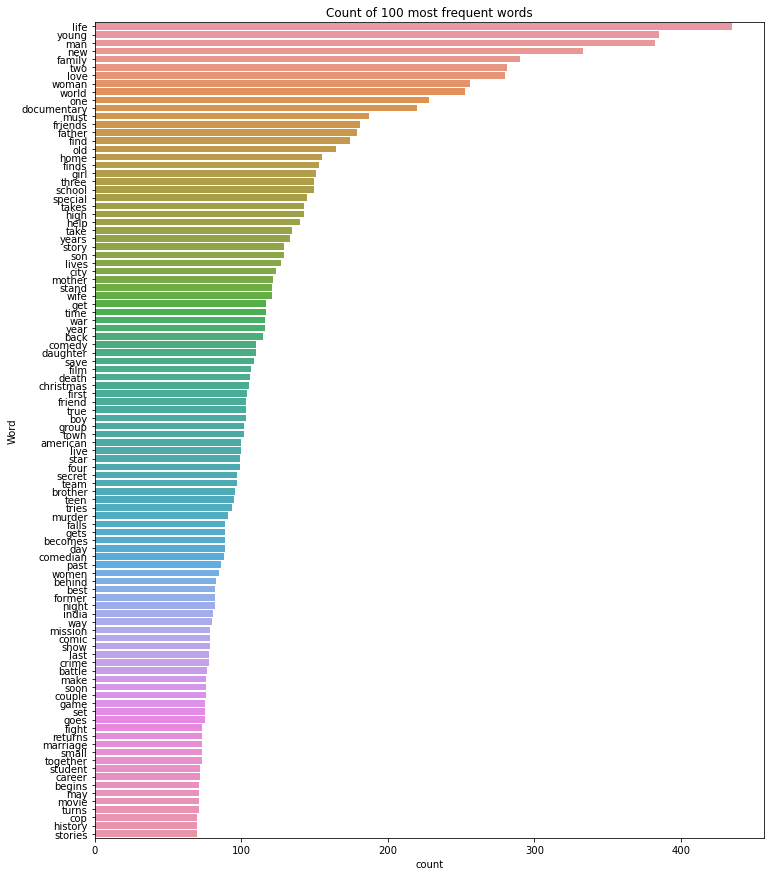

In [11]:
# Check most frequent words after removing stopwords
freq_words(new_set['title_description'], 100)

## Genre predictions

Since we have a multi label data set (one movie can have multiple genres), we need to transform the target variable (genres) into separate target variables.
We use the Binary Relevance approach to assign the genre to the unique target label.

The sklearn MultiLabelBinarizer allows us to encode multiple labels per instance saved in a class label. This transforms the target into an array of binary values where 1 and 0 at different locations in the arrays represents the genres with one target variable per unique genre. 


In [12]:
#Import MultiLabelBinarizer from sklean
from sklearn.preprocessing import MultiLabelBinarizer 

mlb = MultiLabelBinarizer()

# Fit the label sets and transform target variable
y = mlb.fit_transform(new_set['genre'])


We see that the multi label binarizer represents all genres as a binary array. The labels are stored in the classes_ and can be related to the array by transformation. 

By printing one row from the y where the genres are fitted we see that we get a binary vector with zeros and ones.
By printing the inverse_transform we can see which genres this binary vector represents.

We now have a representation of the target value as described in the introduction to predicting genre from description

In [13]:
# The binary classes:
print(f"Class labels: \n{mlb.classes_} \n")

# We see that the genres are represented as a binary vector with values 0 and 1
# A 1 represents that this row have the genre at this position on the label list.
print(y[3]) # Example
# By taking the inverse transferm we can see that what genre the bianry represents
print(mlb.inverse_transform(y)[3])

Class labels: 
['Action & Adventure' 'Children & Family Movies' 'Comedies'
 'Documentaries' 'Dramas' 'Horror Movies' 'Independent Movies'
 'International Movies' 'Music & Musicals' 'Romantic Movies'
 'Stand-Up Comedy' 'Thrillers'] 

[0 0 0 0 0 0 0 1 0 0 0 1]
('International Movies', 'Thrillers')


To relate the title and description to the genre, we use a method to count the number of words and their frequency and relate this to the genre. The method chosen is the sklean TF-IDF Vectorizer. TF-IDF stands for Term Frequency — Inverse Document Frequency and is a statistic that aims to better define how important a word is for a document, while also taking into account the relation to other documents from the same corpus. TfidVectorizer transforms text to feature vectors that can be used as input to estimator.

The data set used is relatively short, and as seen above, the 100th most frequent word after removing stopwords is only used about 70 times. It was therefore decided to initialize the TfidVectorizer with the 1000 most frequent words using max_features = 1000. To make sure we don@t have an over-representation of some words with a very high frequency, max_df was set to 0.8, so that words with frequency higher than 80% is filtered out. 

The data set is then split into train and validation sets for training and evaluating the model's performance. We have found that an 80-20 split where 80% of the data samples are in the train set and the rest are in the validation set is common. Setting of the random_state parameter ensures same results every time.

In [14]:
# Import TfidVectorizer and train_test_split from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Initialize TfidVectorizer with 1000 most frequent words
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=1000)

# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(new_set['title_description'], y, test_size=0.2, random_state=10)

# create TF-IDF features
# fit_transform(): Learn vocabulary and idf from training set, return document-term matrix
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain) 
xval_tfidf = tfidf_vectorizer.transform(xval)

## How to handle multilabel in a logistic regression model?

The logistic regression model will check input vs one target value and will not work directly on a multilabel target. OneVsRestClassifier is the most commonly used strategy for multiclass classification. The one vs rest will split the multi-label dataset into multiple binary classification problems. If we have the multi-label set (Action, Drama, Horror), then the one vs rest classifier will divide the problem into

- Binary classification problem 1: Action vs Drama, Horror
- Binary classification problem 2: Drama vs Action, Horror
- Binary classification problem 3: Horror vs Action, Drama

This way we can run a logistic regression model on a multilabel target value. We see that the number of calculations will be larger with the the one vs rest classifier. However, the dataset for the netflix catalouge is small enough that the runtime will not be very long. However this approach will be time consuming when there is very large data set. 

https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html?highlight=onevsrestclassifier&fbclid=IwAR3Hm-791LbLCwBVkIUdSFo3hUBiWWUdWQ4AyLYj89uEWSjMuKXR_52HKJY#sklearn.multiclass.OneVsRestClassifier

In [15]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix

In [16]:
lr = LogisticRegression() # Set up the logistic regression model
clf = OneVsRestClassifier(lr)   # make a one vs rest classifier of the logistic regression model

In [17]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression())

In [18]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

## Evaluate results

First we check a randomly picked prediction to check if we get results. We see that this title gives 2 predictions. 

In [19]:
#Check prediciton 
print(y_pred[3])

# Inverse transform to get genres:
print(mlb.inverse_transform(y_pred)[3])


[0 0 0 0 1 0 0 1 0 0 0 0]
('Dramas', 'International Movies')


To evalueate the results we check the confusion matrix for all the genres. This will tell us wheter the prediction is a true positive, true negative, false positive or false negative as seen in the matrix below. 

![confusion_matrix](confusion_matrix.png)

True positive and true negatives are the observations that are correctly predicted and therefore desirable. 

The True Positive (TP) are the correctly predicted positive values which means that the value of actual label and predicted label is yes. E.g. Predicted Drama, actual genre is drama. 

The True Negative (TN) are the correctly predicted negative values which means that the value of actual label and predicted label is no. E.g. Predicted not Drama, actual genre is not Drama. 

The False positives (FP) occurs when actual label is no and predicted label is yes. E.g. Predicted Drama, actual class not Drama.

The False negatives (FN) occurs when actual label is yes and prediced label is no. E.g. predicted not Drama, actual label is Drama. 

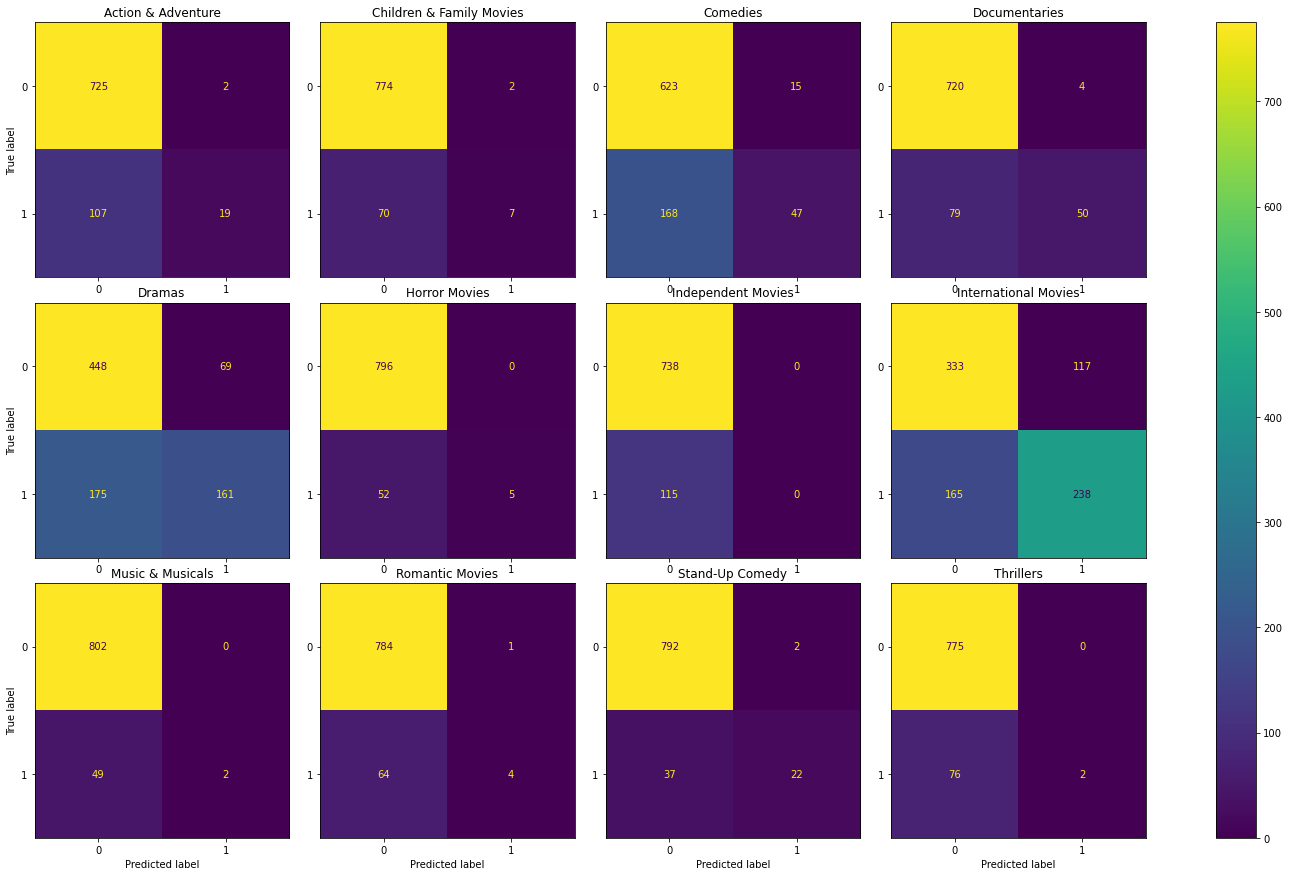

In [21]:
# Make a plot of the confusion matrix for each genre
f, axes = plt.subplots(3, 4, figsize=(25, 15))
axes = axes.ravel()
for i in range(12):
    disp = ConfusionMatrixDisplay(confusion_matrix(yval[:, i],
                                                   y_pred[:, i]),
                                  display_labels=[0, 1])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'{mlb.classes_[i]}')
    if i<8:
        disp.ax_.set_xlabel('')
    if i%4!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

The results show that all predictions have a high True Negative score which is to be expected since there are several genres and some genres have few movies. For the categories with the most movies, such as Dramas and International Movies, the True Positives are higher, but this is quite low for some genres. The false Negative (FN) score on most is higher than we would have liked. 

We then check the classification report which gives the precision score, recall score and f1 score for each genre and combined below. 

The precision score gives the ratio of predicted positive observations to total predicted positive observations: <br>
Precision = TP/(TP+FP)

The Recall (Sensitivity) is the ratio of correctly predicted positive observations to all the observations in class = yes: <br>
Recall = TP/(TP+FN)

F1 score is the weighted average of Precision and Recall. Therefore this score takes both false positives and false negatives into account: <br> 
F1 Score = 2*(Recall * Precision)/(Recall + Precision)

Source: https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/

In [22]:
# Check classification report with precision score, recall score and f1 score.
report = classification_report(yval, y_pred, output_dict=True)
class_df = pd.DataFrame(report).transpose()
gen_list = np.append(mlb.classes_, ["","","",""])
class_df['genre'] = gen_list
class_df

C:\Users\ASLAKSK\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASLAKSK\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASLAKSK\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support,genre
0,0.904762,0.150794,0.258503,126.0,Action & Adventure
1,0.777778,0.090909,0.162791,77.0,Children & Family Movies
2,0.758065,0.218605,0.339350,215.0,Comedies
3,0.925926,0.387597,0.546448,129.0,Documentaries
4,0.700000,0.479167,0.568905,336.0,Dramas
5,1.000000,0.087719,0.161290,57.0,Horror Movies
6,0.000000,0.000000,0.000000,115.0,Independent Movies
7,0.670423,0.590571,0.627968,403.0,International Movies
8,1.000000,0.039216,0.075472,51.0,Music & Musicals
9,0.800000,0.058824,0.109589,68.0,Romantic Movies


We see that the precision score is generally high for most genres, except Independent Movies, giving a micro average of 0.72. This is generally quite good. The recall score is quite low for some genres due to the large amount of false negatives for some of the genres. The micro average for recall is 0.32. This gives an f1 score of 0.44.

## Predictions

To show how the model predicts the genres, we pick 50 random movies in the data set and check them in the model and print the results. 

We see that the model predicts the large genres such as International Movies and Dramas quite well and also smaller genres such as Stand-Up Comedy, probably due to the prevalence of words like comedian and stand-up in these descriptions. The model is though hesitant to give predictions to several movies, which leads to a several false negatives and a low recall score. 

In [24]:
# Function to predict genre using method above for a given movie
def predict_tags(q):
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return mlb.inverse_transform(q_pred)

In [25]:
# Print movie title, predicted genre and actial genre for 50 random movies
for i in range(50): 
  k = xval.sample(1).index[0] 
  print("Movie: ", new_set['title'][k], "\nPredicted genre: ", predict_tags(xval[k])), print("Actual genre: ",new_set['genre'][k], "\n")


Movie:  Bright 
Predicted genre:  [('International Movies',)]
Actual genre:  ['Action & Adventure'] 

Movie:  Look for a Star 
Predicted genre:  [()]
Actual genre:  ['International Movies', 'Comedies', 'Romantic Movies'] 

Movie:  Lust Stories 
Predicted genre:  [('Dramas', 'International Movies')]
Actual genre:  ['International Movies', 'Comedies', 'Dramas'] 

Movie:  Casino Tycoon 2 
Predicted genre:  [()]
Actual genre:  ['Action & Adventure', 'International Movies', 'Dramas'] 

Movie:  Shanghai Fortress 
Predicted genre:  [('Dramas', 'International Movies')]
Actual genre:  ['International Movies', 'Romantic Movies', 'Dramas'] 

Movie:  We Are Family 
Predicted genre:  [('Dramas',)]
Actual genre:  ['International Movies', 'Dramas'] 

Movie:  Shorgul 
Predicted genre:  [('Dramas', 'International Movies')]
Actual genre:  ['International Movies', 'Dramas'] 

Movie:  Paskal 
Predicted genre:  [('Dramas', 'International Movies')]
Actual genre:  ['Action & Adventure', 'International Movies

## Evaluation of Model and Data Set

The cleaning of the data set was important to get an OK precision score. 

At first we tried to use the model to predict the genre with the complete data set and using the description only. The classification report for this is shown below. We see that this gave a low or 0 score for precision for a lot of categories. We could see that it would not be possible to get good predictions without removing some of the genres. Most of the TV genres gave a lower score and it was therefore decided to try to only use movies. In addition we added the title to the prediction data to increase the number of words that could be used.

![pre_data_clean](pre_genre_clean.png)

The model can still not predict all genres. To get a model that can predict everything we either need a larger dataset to get more words to relate to each genre, or perhaps use methods like word embedding where someone has made a database of words that has already been trained such that words like house and home are given related meaning. We could also try to combine more of the genres that are similar. 

The model is best at predicting genres where there are many movies, and has problems with the less frequent genres. 